# 1. Fitting Ne lines in a loop
- This is the first step of fitting Diad data
- This notebook shows how to fit all lines in a folder defined by path
- You tweak the fit for a single line, and then use this to fit all lines. You can then refit lines with high residuals/offsets differing from the rest

## Downloading locally
- You can install DiadFit through PyPI, simply uncomment this line. You only need to run this once per computer (until you want to get an upgraded version)
- Uncomment this line if you havent installed DiadFit, or are running a much older version. 

In [1]:
#!pip install --upgrade DiadFit

## Now import the packages you need
- When you communicate bugs with Penny, make sure you specify the version here.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import DiadFit as pf
# This needs to be 0.0.68 or higher!
pf.__version__

'0.0.77'

##  Specifying paths
- Put your path here, e.g. where in your computer the spectra and metadata are saved

In [3]:
import os
DayFolder=os.getcwd()
meta_path=DayFolder +  '\MetaData'
spectra_path=DayFolder + '\Spectra'
filetype='headless_txt'
# What is your file extension? .txt, .csv, .xlsx?
file_ext='.txt'
# Does your file start with a prefix? E.g 01 Ne_line.txt?
prefix=True
prefix_str=' '

# Does your instrument have TruPower (WITEC)
TruPower=True
# Save settings to a file to use in all other notebooks
pf.save_settings(meta_path, spectra_path, filetype, prefix, prefix_str, file_ext, TruPower)


In [4]:
# This step gets all your Ne files. Enter ID_str as a string in only your Neon files, exclude strings not in Ne files. So here we take files with 'Ne' in the name and exclude those with 'diad' in the name. 
Ne_files=pf.get_files(path=spectra_path,
file_ext='txt', ID_str='Ne', 
exclude_str=['diad'], sort=False)

Ne_files

['01 Ne1.txt',
 '02 Ne2.txt',
 '03 Ne3.txt',
 '04 Ne4.txt',
 '05 Ne5.txt',
 '09 Ne6.txt',
 '13 Ne7.txt',
 '17 Ne8.txt',
 '19 Ne9.txt',
 '21 Ne10.txt',
 '23 Ne11.txt',
 '26 Ne12.txt',
 '29 Ne13.txt',
 '32 Ne14.txt',
 '35 Ne15.txt',
 '37 Ne16.txt',
 '41 Ne17.txt',
 '43 Ne18.txt',
 '45 Ne19.txt',
 '50 Ne20.txt',
 '54 Ne21.txt',
 '57 Ne22.txt',
 '59 Ne23.txt',
 '60 Ne24.txt']

### Get Ne line positions for your specific laser wavelength
- At the moment, this returns any Ne lines with intensity >2000 in the NIST databook, although you can change this!

In [5]:
wavelength =532.046 # Specify the specific wavelength of your laser 
df_Ne=pf.calculate_Ne_line_positions(wavelength=wavelength, 
cut_off_intensity=2000)
df_Ne.head()

Raman_shift (cm-1)  Intensity  Ne emission line in air
1           818.699523     5000.0                556.27662
9          1117.086987     5000.0                565.66588
16         1310.480205     5000.0                571.92248
19         1398.915133     5000.0                574.82985
23         1447.564622     7000.0                576.44188

### Calculate the ideal distance between the two lines you are selecting
- This finds the closest line in the table above for each selected line

In [6]:
line_1=1219
line_2=1447
ideal_split=pf.calculate_Ne_splitting(wavelength=wavelength, 
line1_shift=line_1, line2_shift=line_2,
cut_off_intensity=100)
ideal_split

Ne_Split       Line_1       Line_2  Entered Pos Line 1  \
0  227.457159  1220.107463  1447.564622                1219   

   Entered Pos Line 2  
0                1447

## Select one file to tweak the fit for
- You can either do this numerically, or by specifiying the filename between ''

In [7]:
i=0 # Select one file
filename=Ne_files[i] 
print(filename)

01 Ne1.txt


## Plot Ne lines to inspect
- This function allows you to inspect your spectra, and also uses scipy find peaks to get a first guess of the peak positions, which speeds up the voigt fitting in the later part of the notebook
- This also prints the heights of the other peaks so you could choose other Neons if you wanted to

Peak1_cent  Peak1_height   Peak2_cent  Peak2_height   Peak1_prom  \
0  1219.691051        3017.0  1447.663174       37490.0  2296.333313   

     Peak2_prom  
0  36769.333313

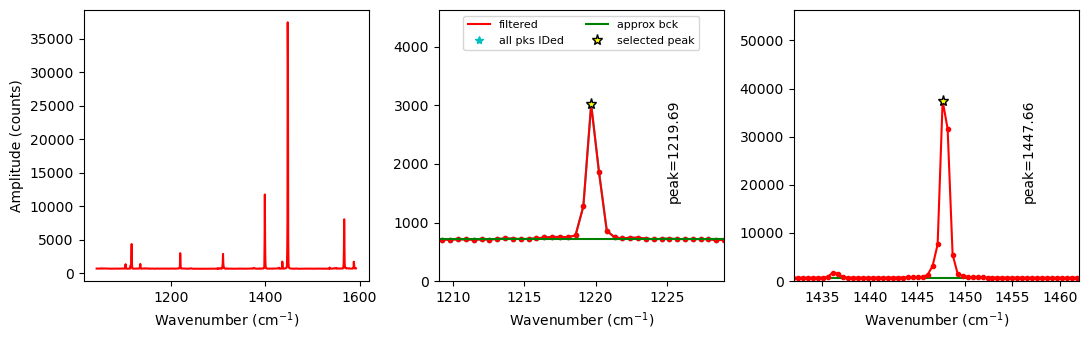

In [8]:
exclude_range_1=None
exclude_range_2=None

Neon_id_config=pf.Neon_id_config(height=10,  distance=1, prominence=10, 
            width=1, threshold=0.6,
            peak1_cent=line_1, peak2_cent=line_2, n_peaks=6, 
            exclude_range_1=exclude_range_1, 
            exclude_range_2=exclude_range_2)
Neon_id_config

Ne, df_fit_params=pf.identify_Ne_lines(path=spectra_path,
filename=filename, filetype=filetype,
config=Neon_id_config, print_df=False)
df_fit_params

### Tweak peak parameters
- One important thing is the background positions, these are defined relative to the peak position. Once you tweak them for each instrument, you chould be good to go. 
- Another thing is how many peaks you want for Peak1, 'peaks_1', for the 1117 line, you'll need 2 if you have the clear secondary peak seen above. 

In [9]:
pf.Ne_peak_config()

Ne_peak_config(model_name='PseudoVoigtModel', N_poly_pk1_baseline=1, N_poly_pk2_baseline=1, lower_bck_pk1=(-50, -25), upper_bck1_pk1=(8, 15), upper_bck2_pk1=(30, 50), lower_bck_pk2=(-44.2, -22), upper_bck1_pk2=(15, 50), upper_bck2_pk2=(50, 51), peaks_1=2, DeltaNe_ideal=330.477634, x_range_baseline_pk1=20, y_range_baseline_pk1=200, x_range_baseline_pk2=20, y_range_baseline_pk2=200, pk1_sigma=0.4, pk2_sigma=0.4, x_range_peak=15, x_range_residual=7, LH_offset_mini=(1.5, 3), x_span_pk1=None, x_span_pk2=None)

In [10]:
model_name='PseudoVoigtModel'
Ne_Config_est=pf.Ne_peak_config(model_name=model_name,
 DeltaNe_ideal=ideal_split['Ne_Split'], peaks_1=1, 
pk1_sigma=0.6, lower_bck_pk1=(-40, -20), upper_bck1_pk1=[30, 50], upper_bck2_pk1=[30, 50],
pk2_sigma=0.6, lower_bck_pk2=[-40, -30], upper_bck1_pk2=[10, 15], upper_bck2_pk2=[25, 40],
x_range_peak=5, x_span_pk1=[-10, 8], x_span_pk2=[-10, 10],
N_poly_pk2_baseline=2 )



filename  1σ_Ne_Corr_test  1σ_Ne_Corr  pk2_peak_cent  pk2_amplitude  \
0  Ne1.txt          0.00002     0.00002    1447.883401   46437.290495   

   pk2_sigma pk2_gamma  error_pk2  Peak2_Prop_Lor  pk1_peak_cent  ...  \
0   0.419338      None    0.00236        0.400013    1219.795607  ...   

   pk1_gamma  error_pk1 Peak1_Prop_Lor     deltaNe   Ne_Corr  Ne_Corr_min  \
0       None   0.003818       0.463183  228.087794  0.997235     0.997208   

   Ne_Corr_max  residual_pk2  residual_pk1  residual_pk1+pk2  
0     0.997262    109.967944     15.820996         125.78894  

[1 rows x 22 columns]

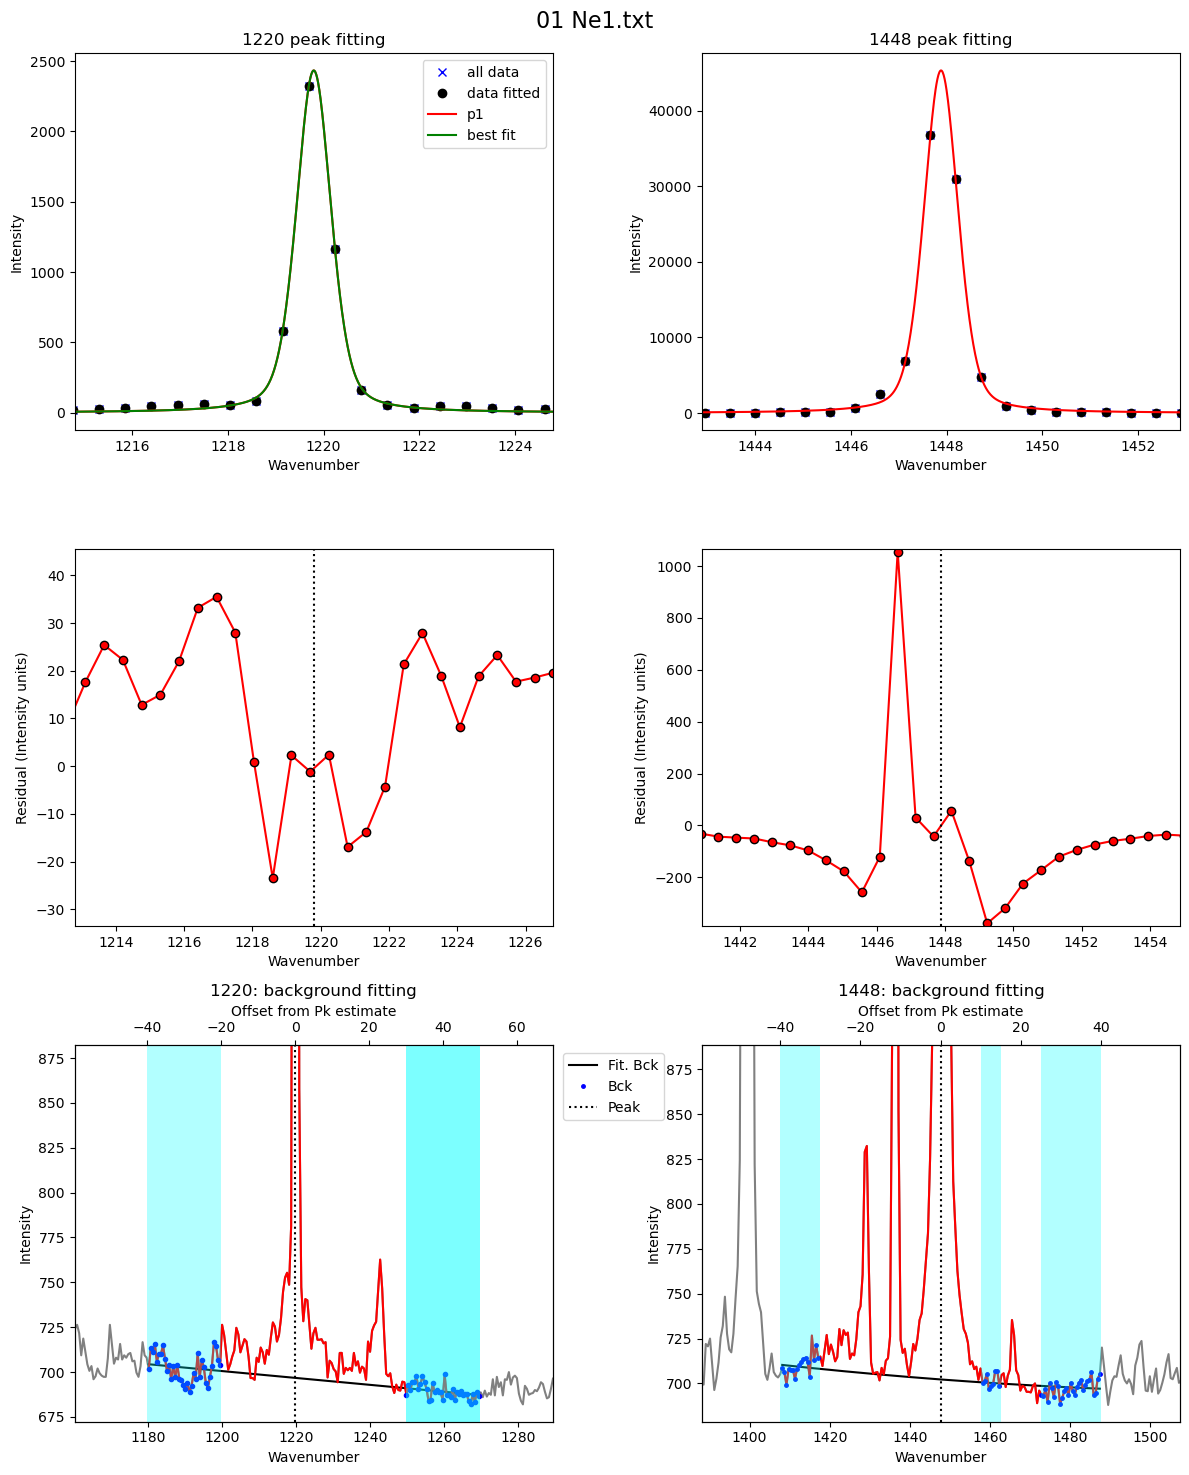

In [11]:

df_test_params=pf.fit_Ne_lines(Ne=Ne, filename=filename,
path=spectra_path, prefix=prefix,
config=Ne_Config_est,
    Ne_center_1=df_fit_params['Peak1_cent'].iloc[0], 
    Ne_center_2=df_fit_params['Peak2_cent'].iloc[0],
    Ne_prom_1=df_fit_params['Peak1_prom'].iloc[0],
    Ne_prom_2=df_fit_params['Peak2_prom'].iloc[0],
    const_params=False)                                                                 
                                                                     
display(df_test_params)

In [12]:
## Now tweak the values of the sigma to help with the looping - then for looping we let these parameters only vary +-20% between spectra
Ne_Config_est.pk1_sigma=df_test_params['pk1_sigma'][0]
Ne_Config_est.pk2_sigma=df_test_params['pk2_sigma'][0]


## Now fit all Ne files here using these parameters. 
- If you select plot_figure=False, the loop will be quick. 
- But if its True, you can to inspect the figures.

  0%|          | 0/24 [00:00<?, ?it/s]

c:\users\penny\box\berkeley_new\diadfit_outer\src\DiadFit\ne_lines.py:1220: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ((ax3, ax2), (ax5, ax4), (ax1, ax0)) = plt.subplots(3,2, figsize = (12,15)) # adjust dimensions of figure here


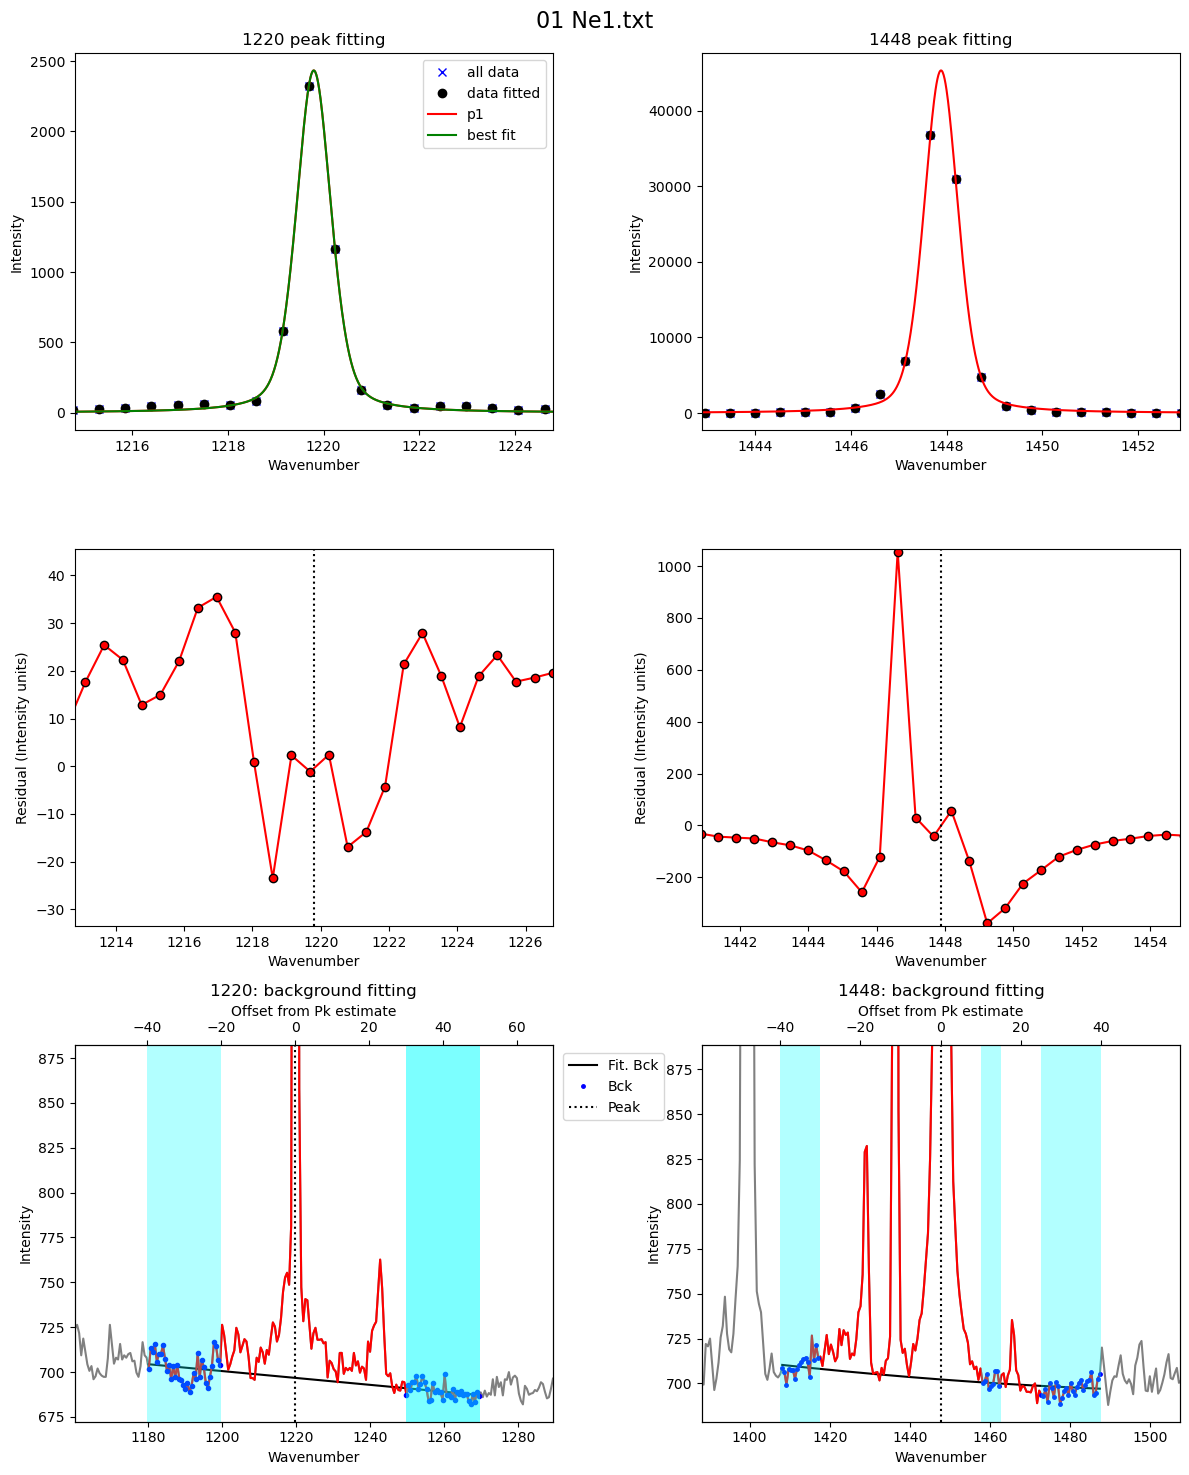

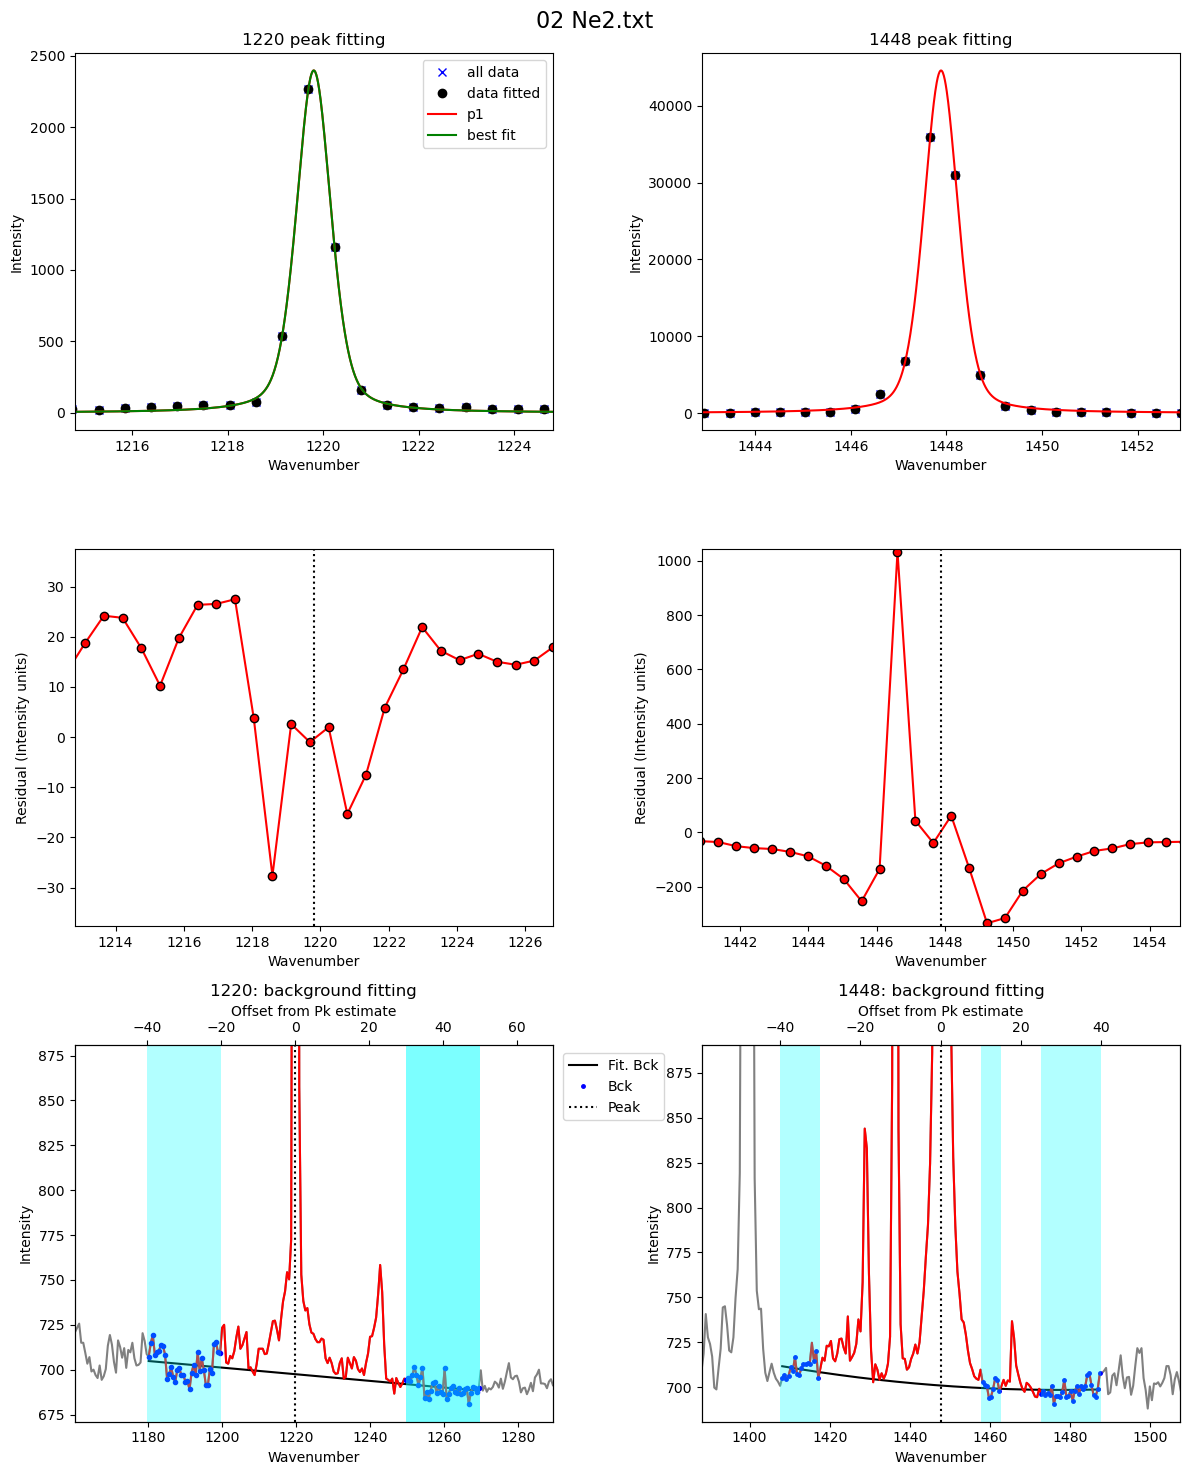

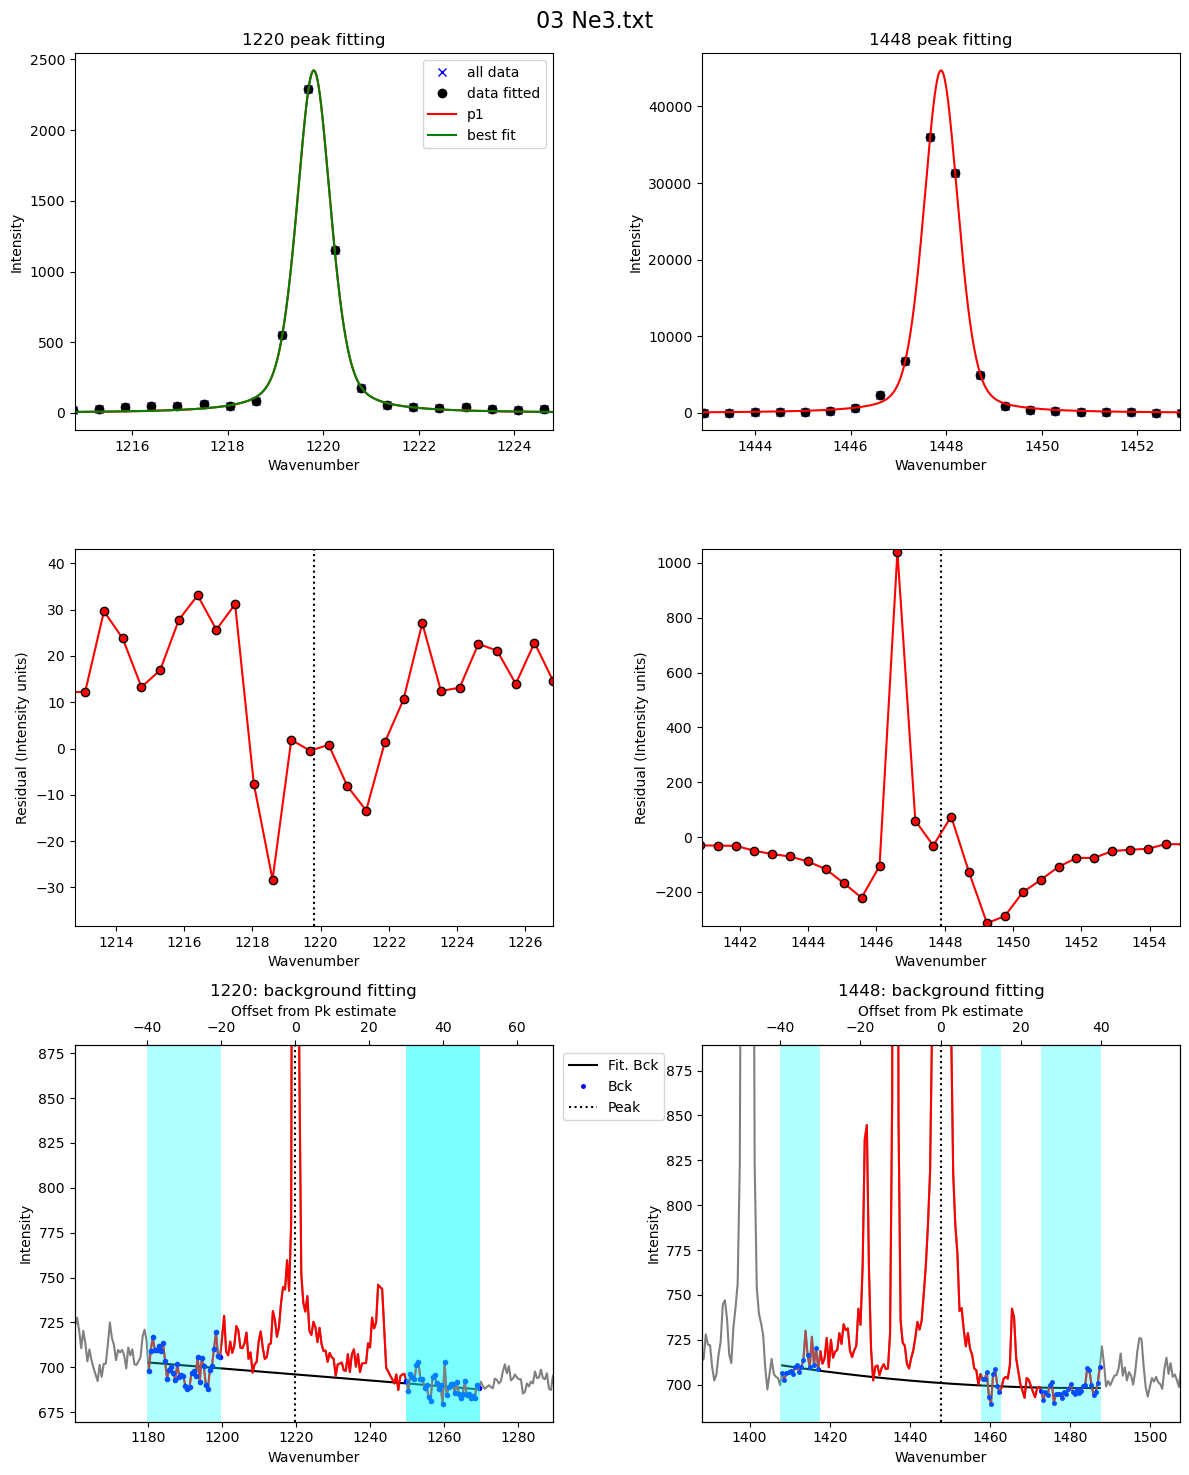

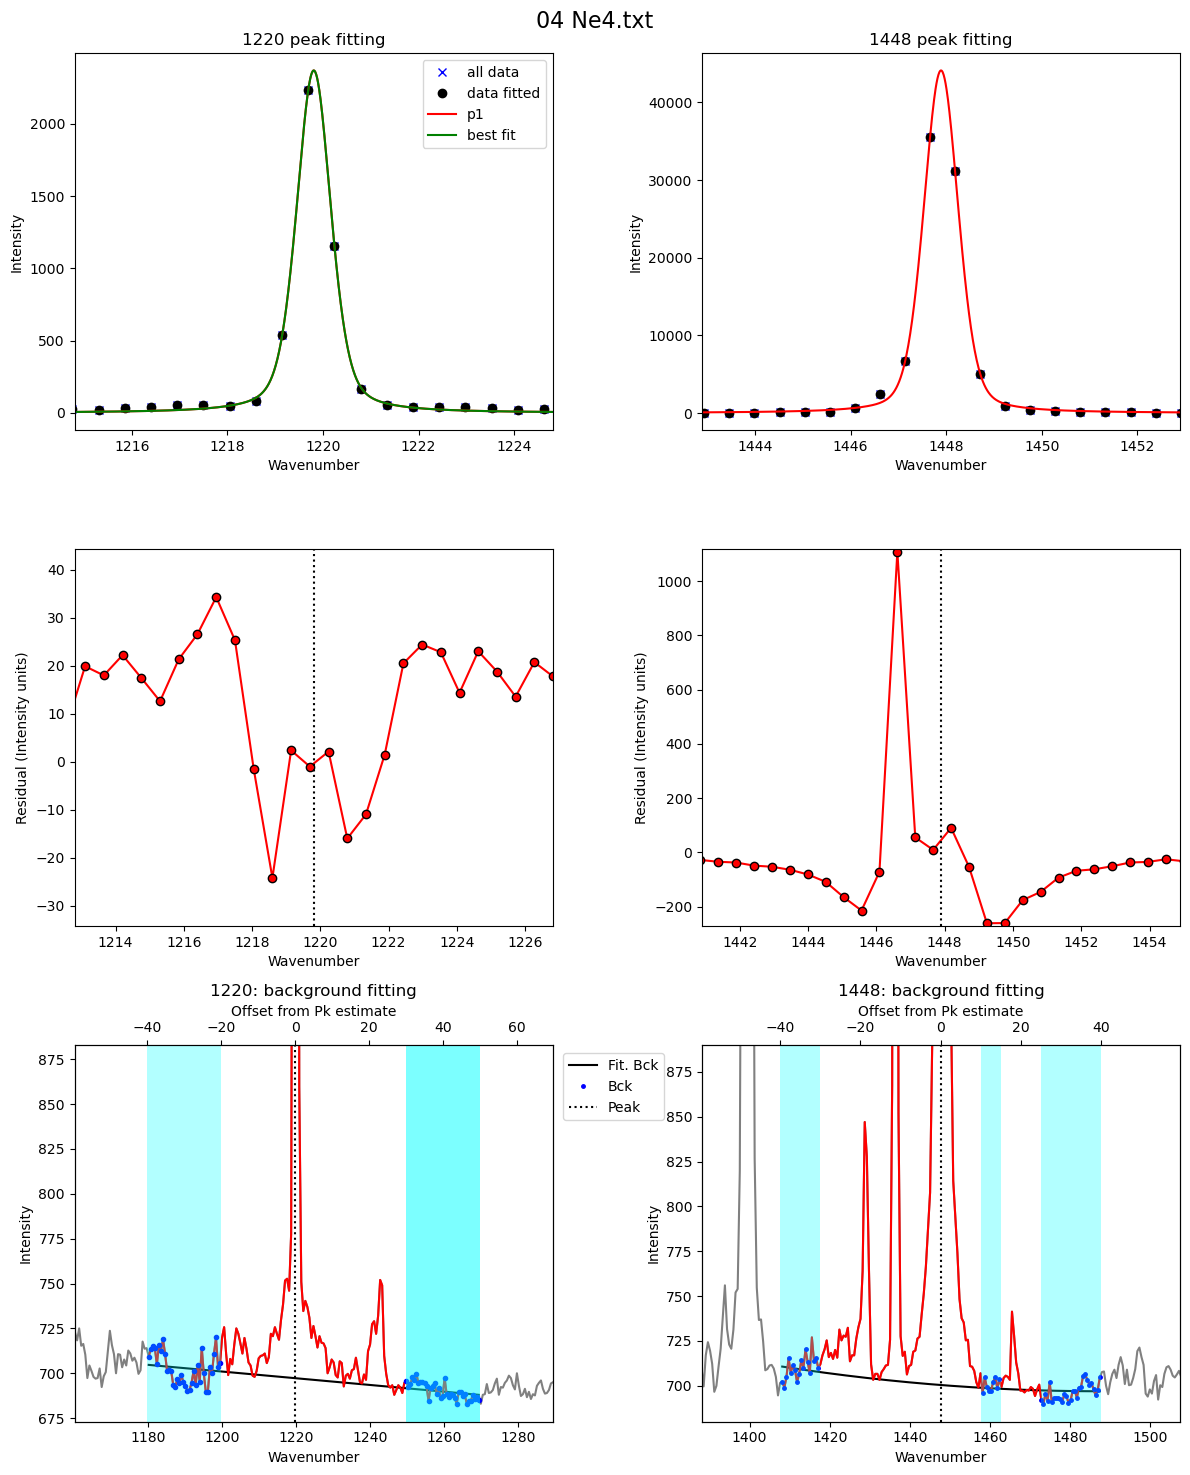

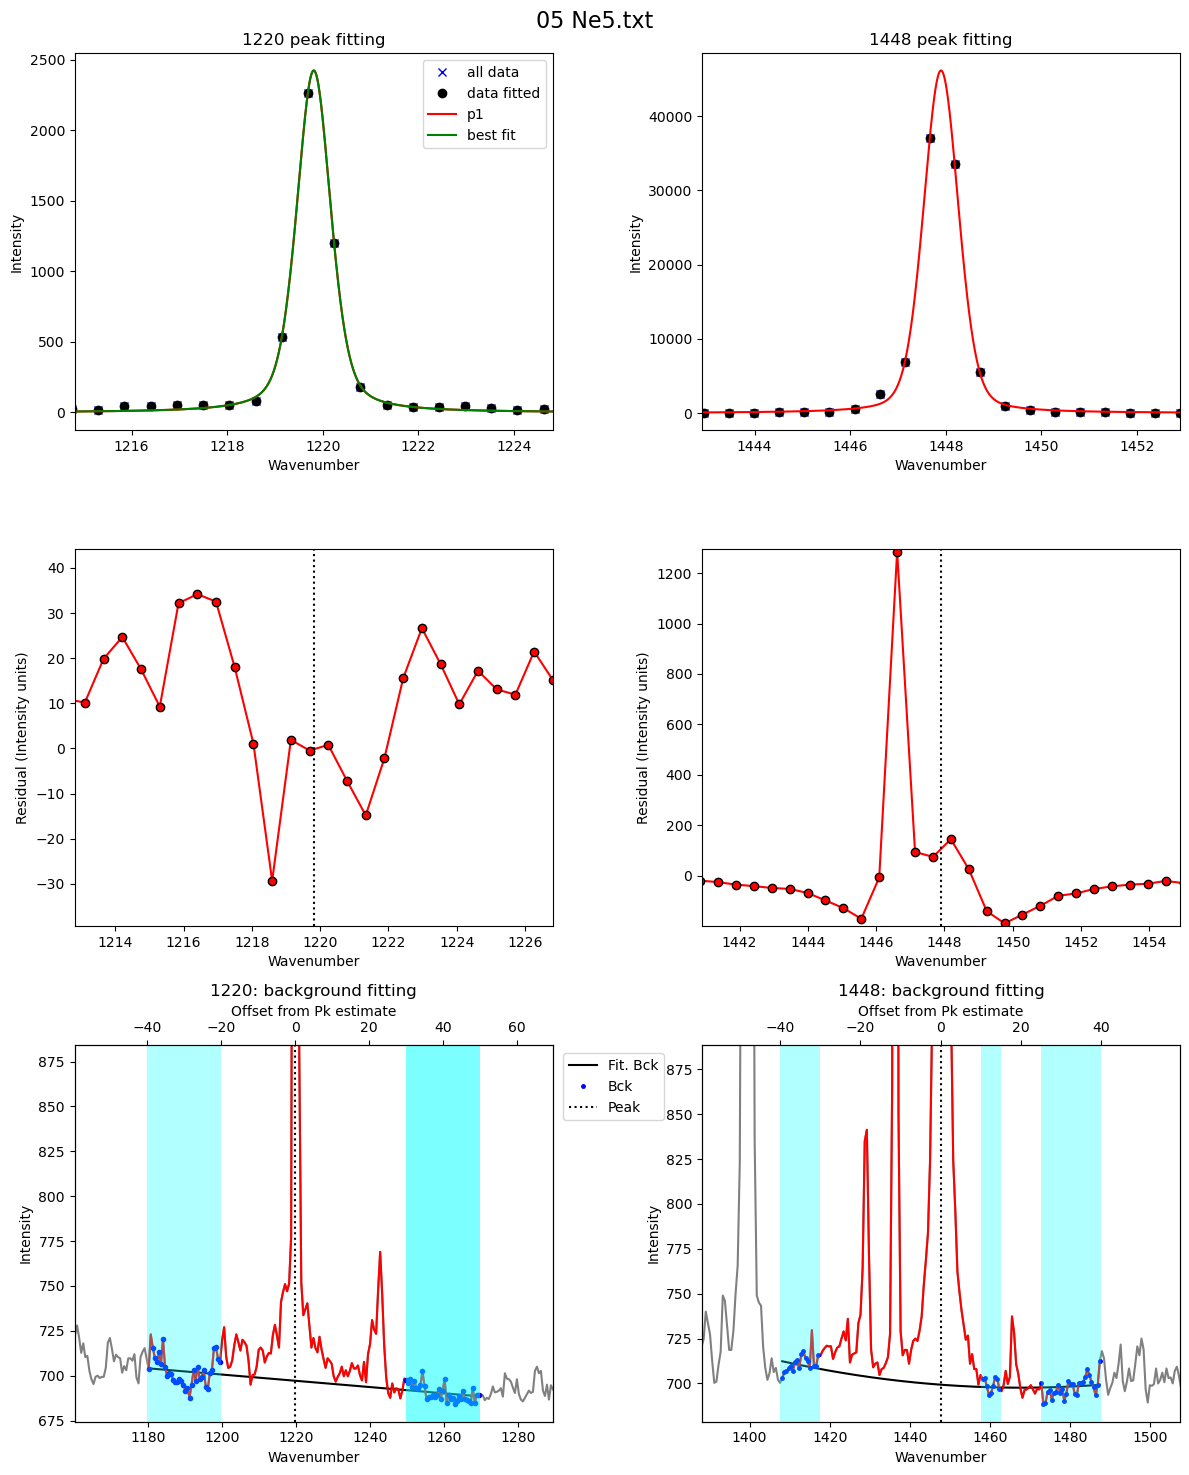

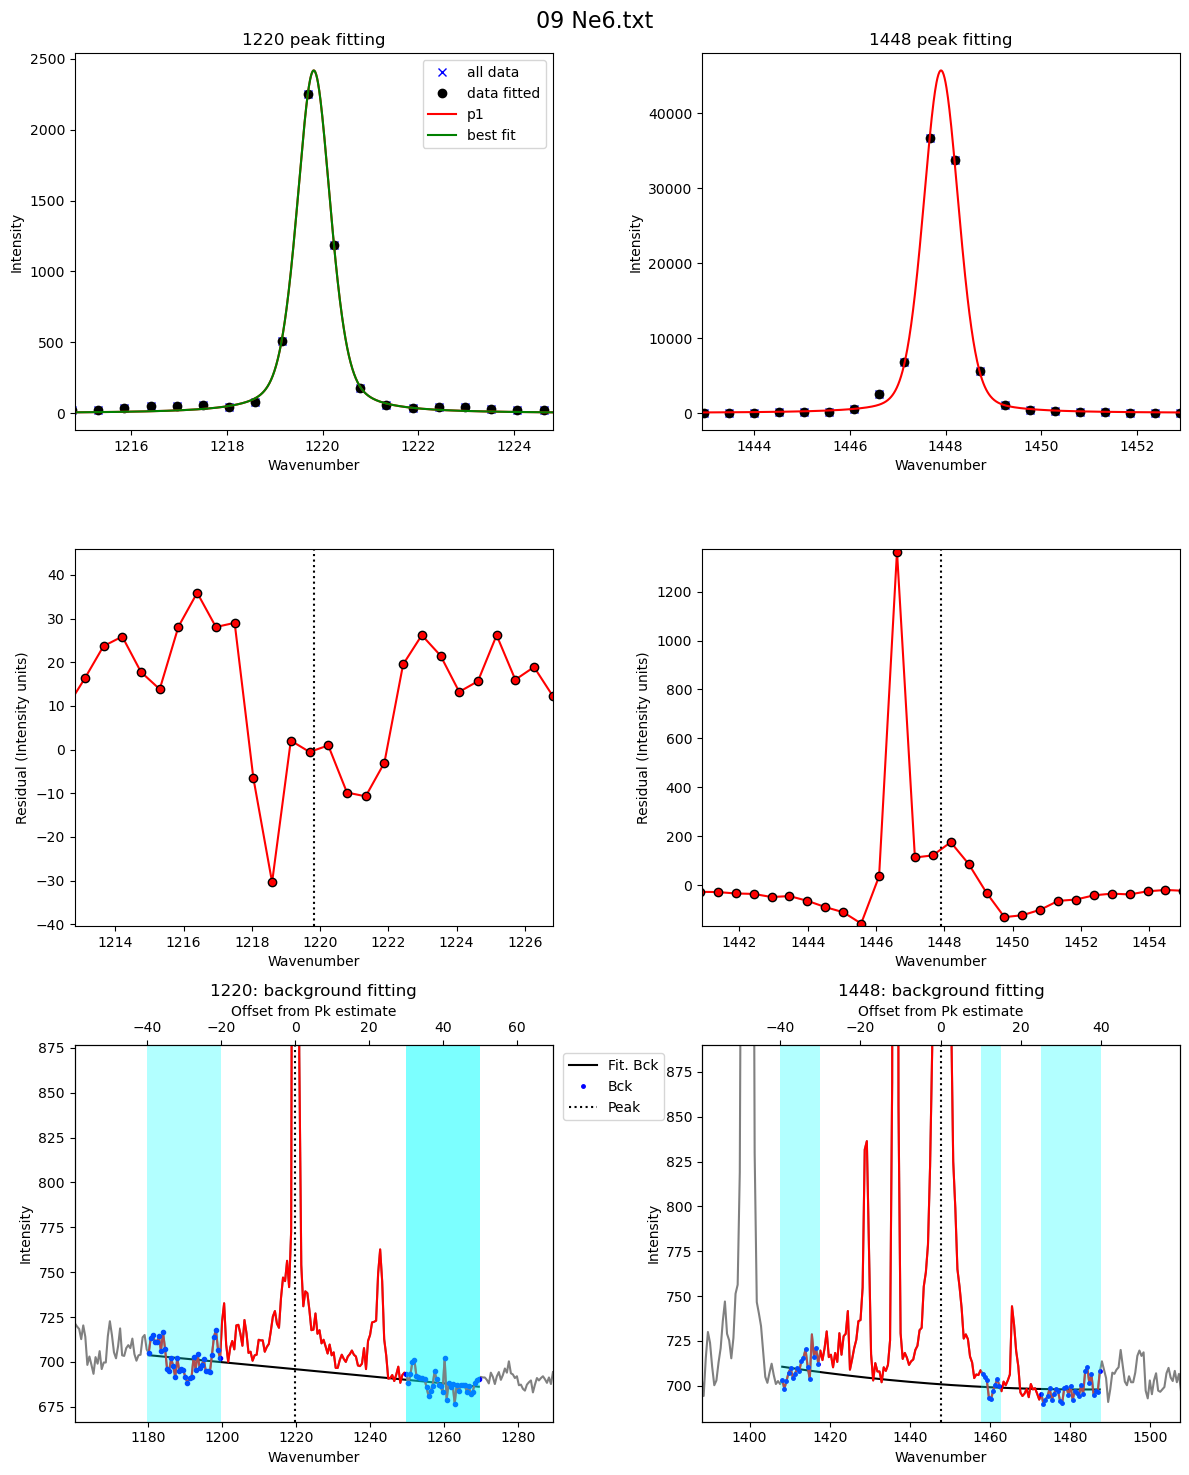

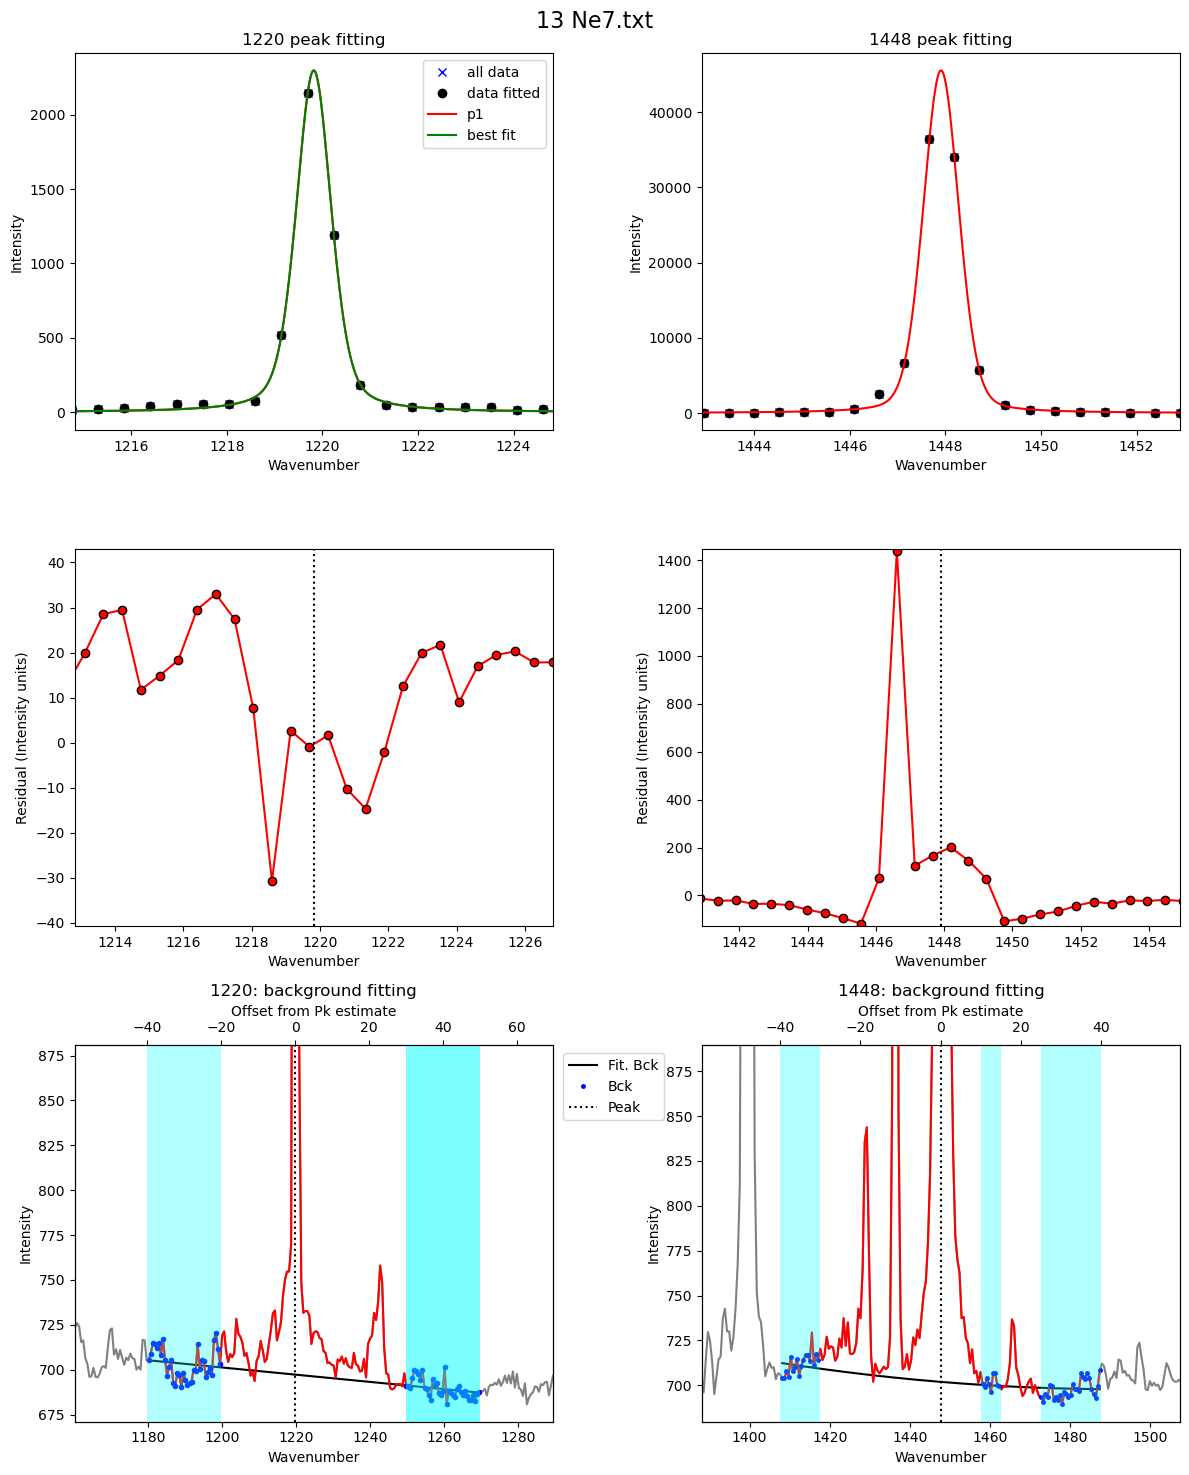

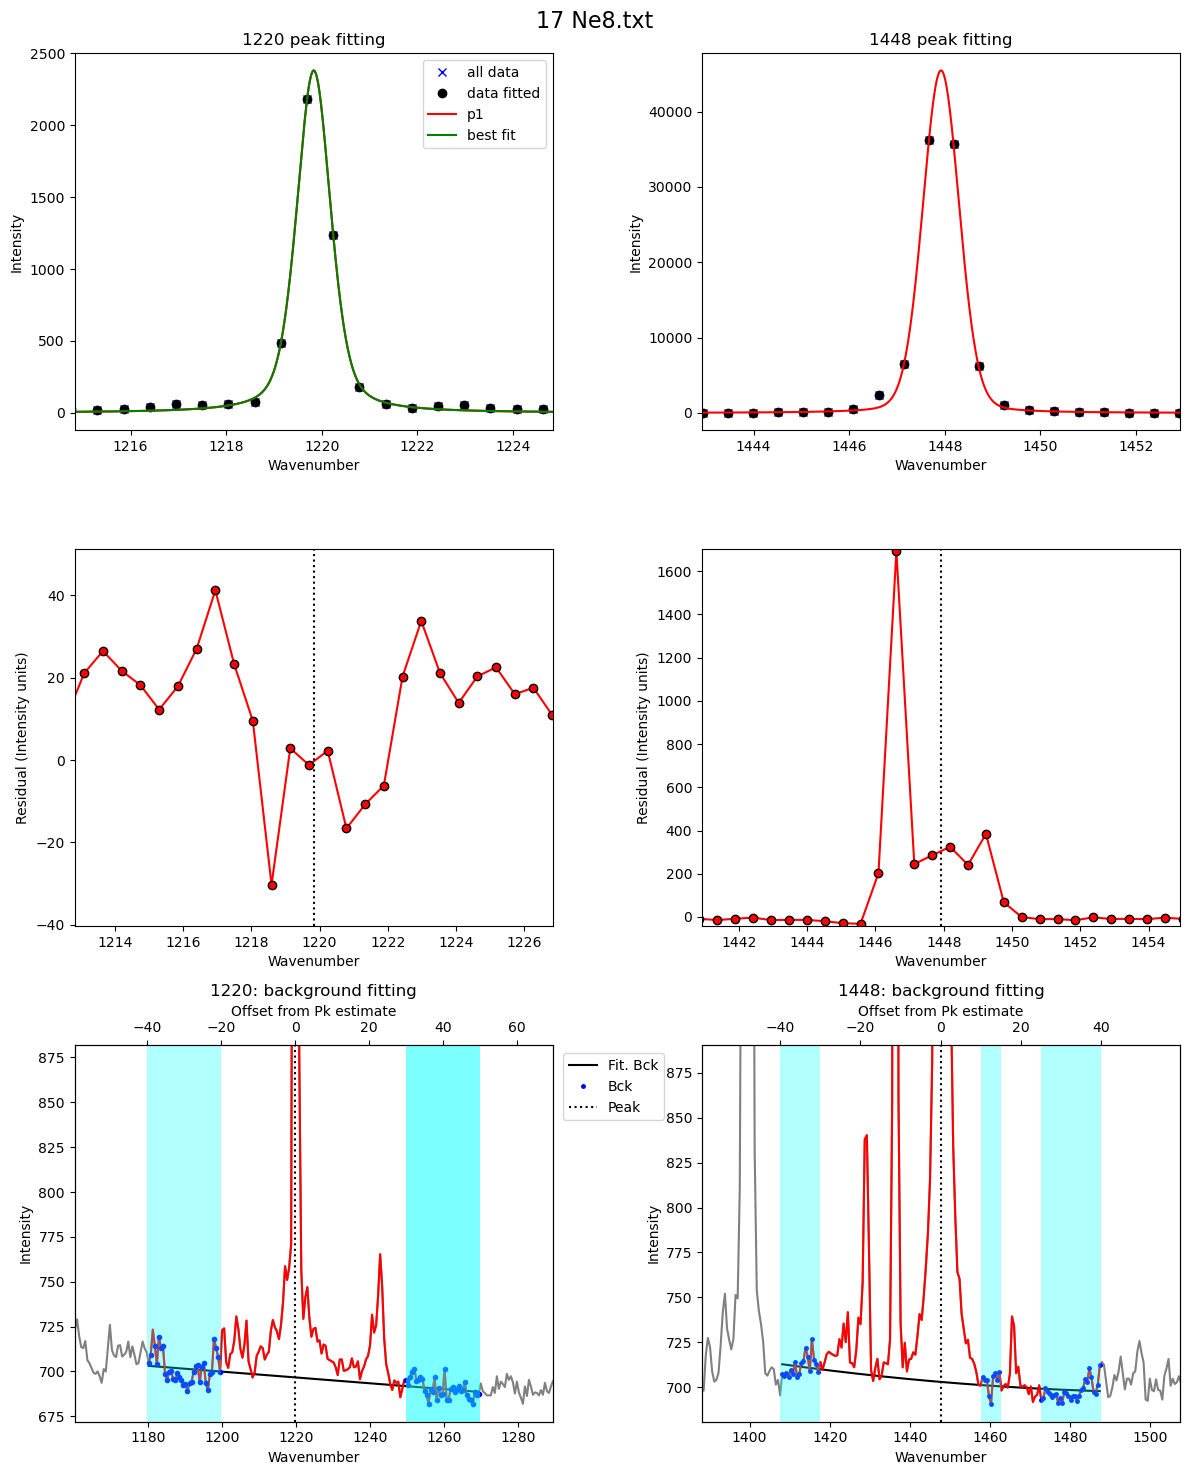

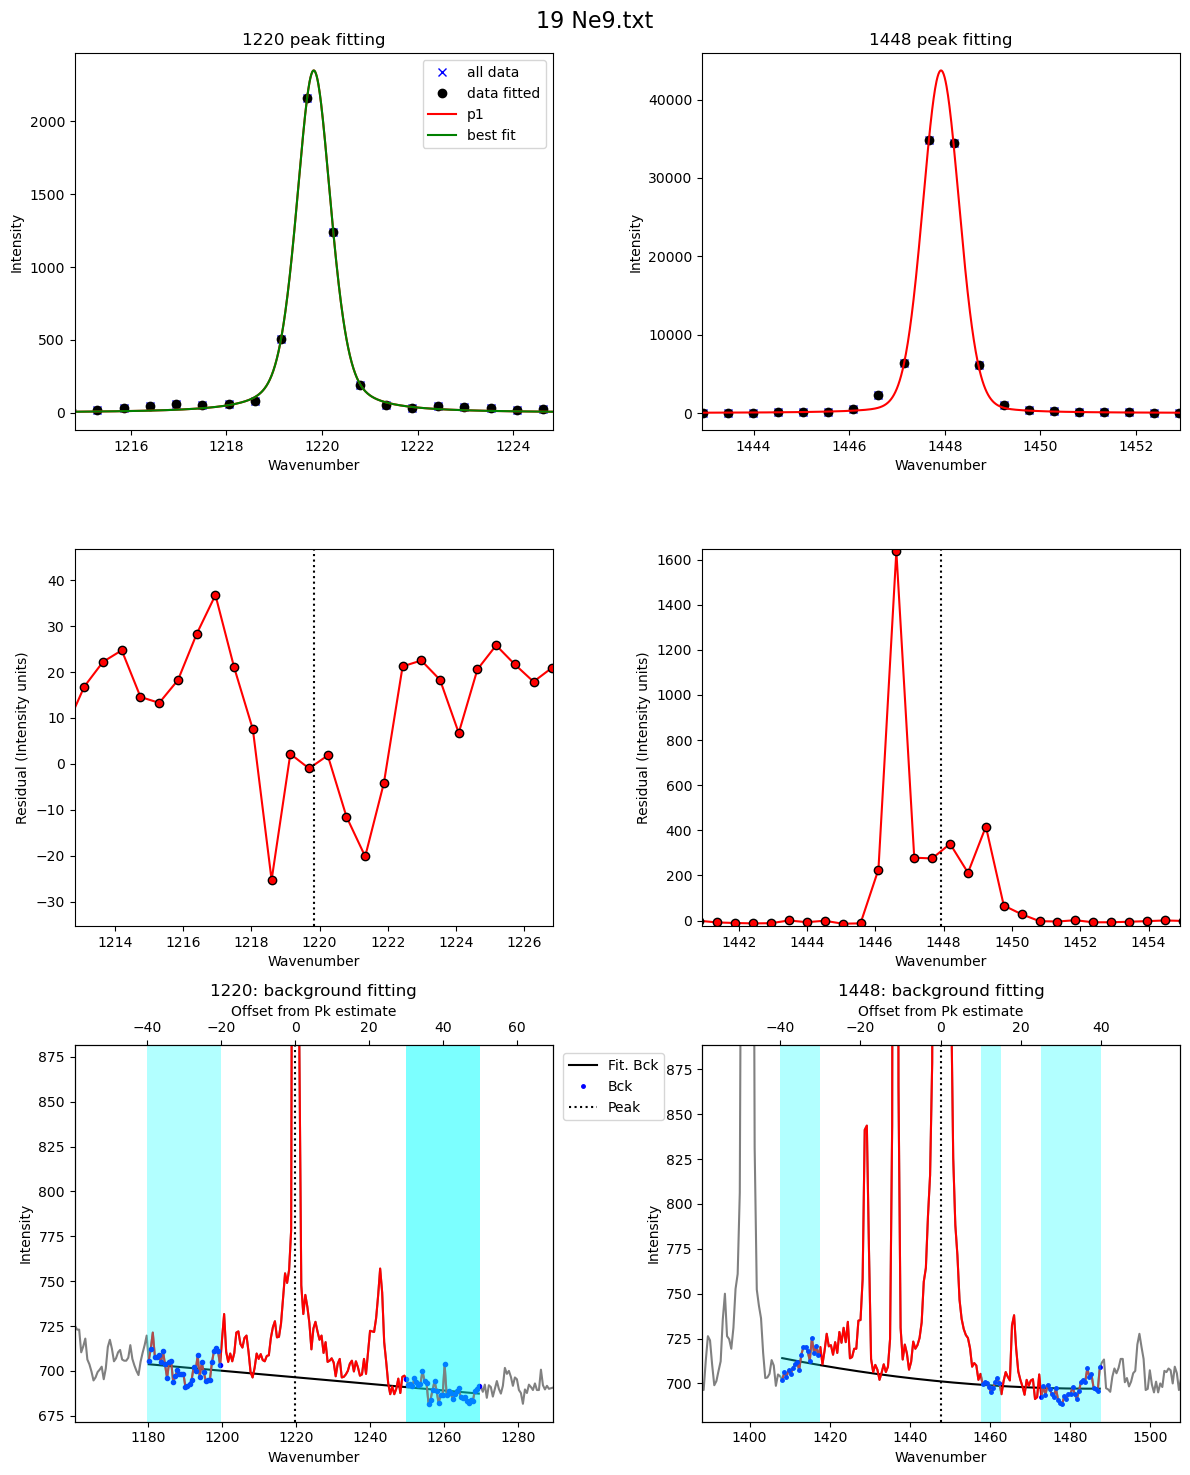

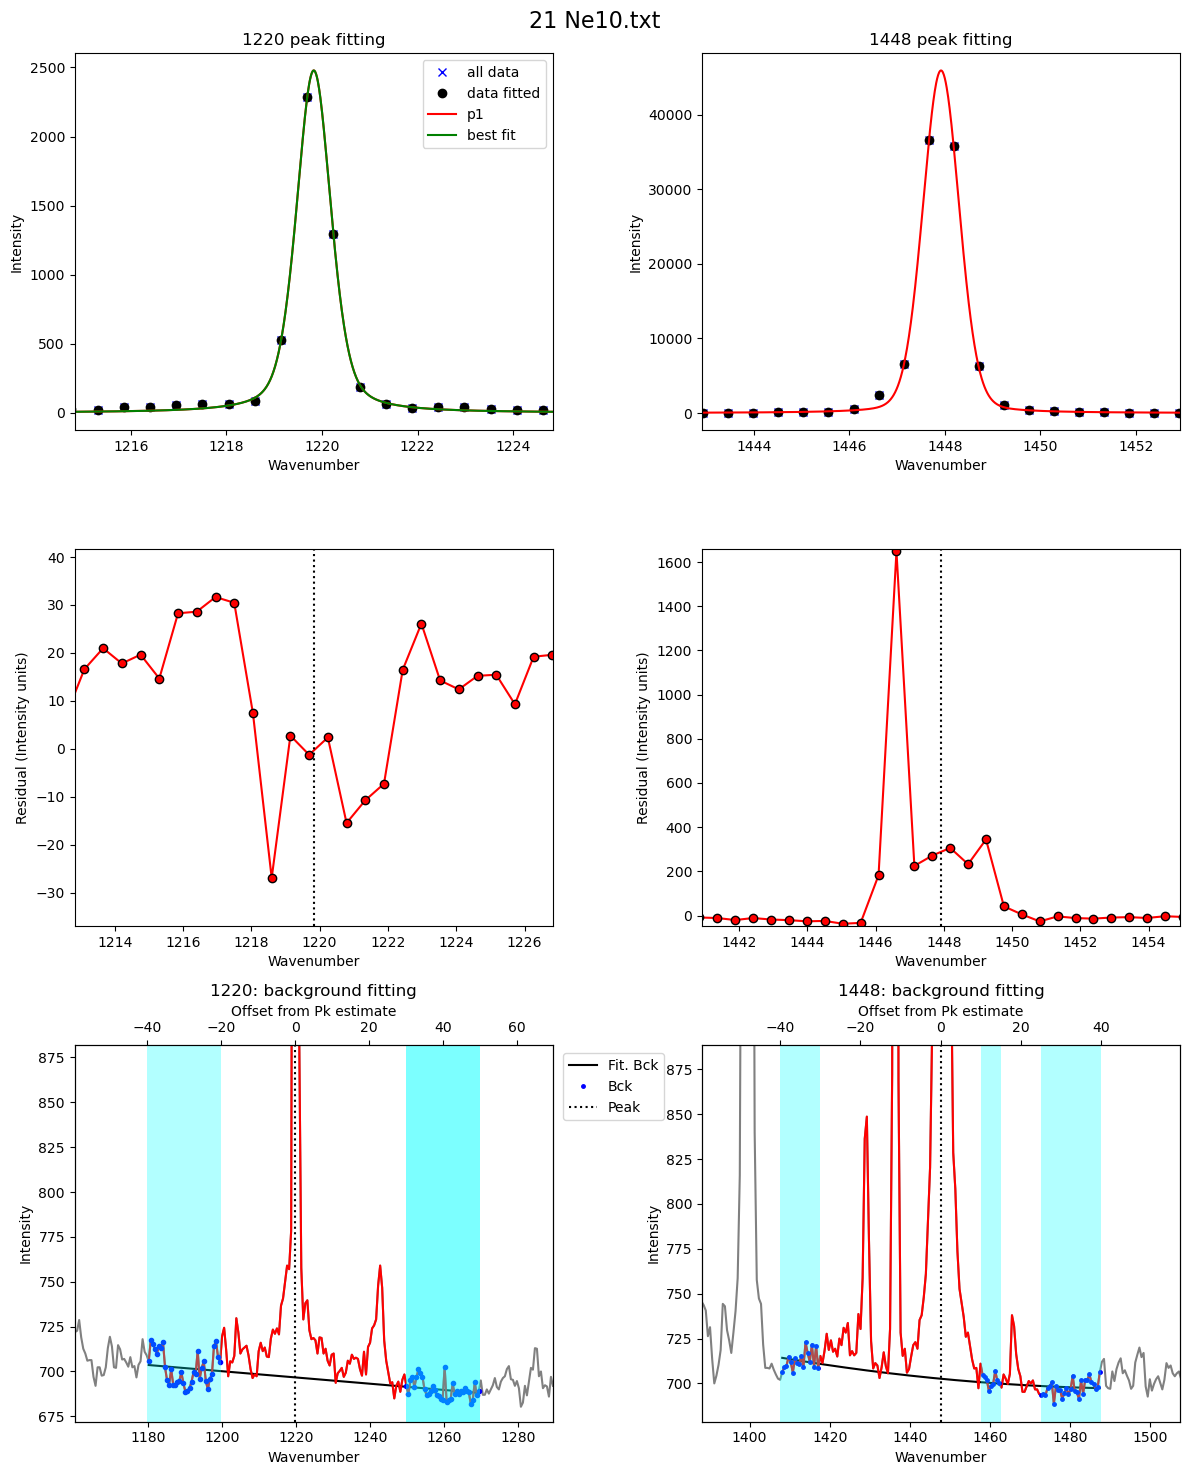

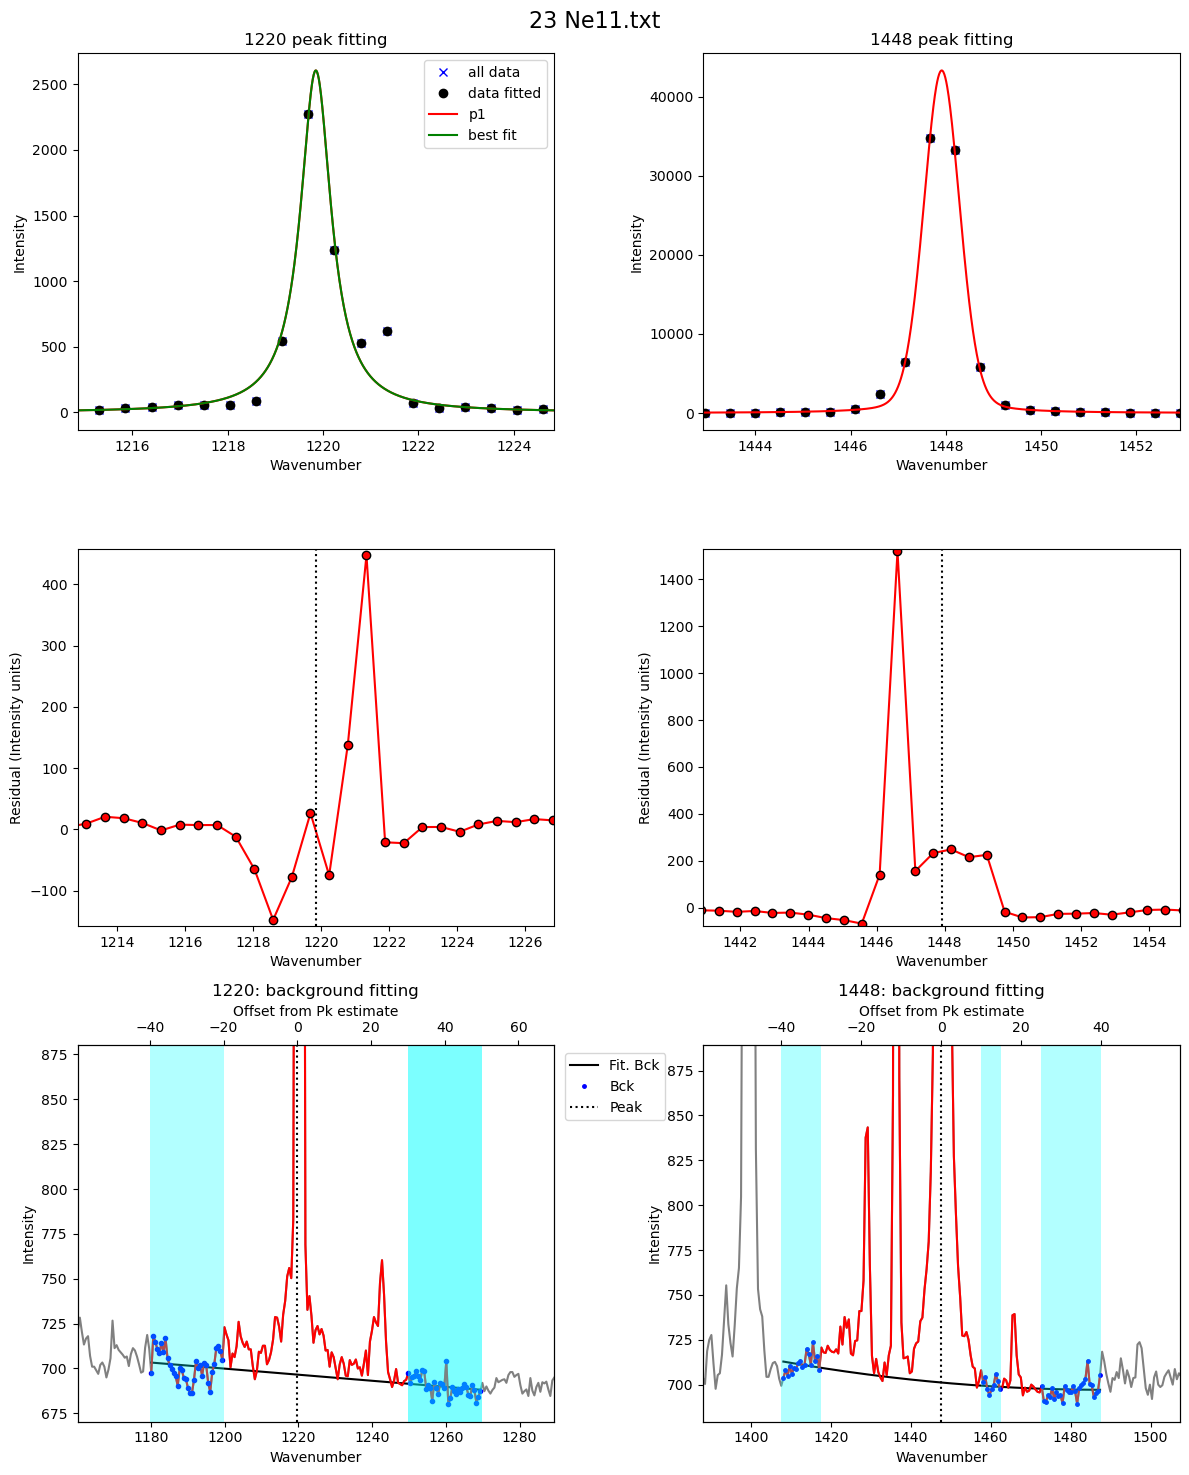

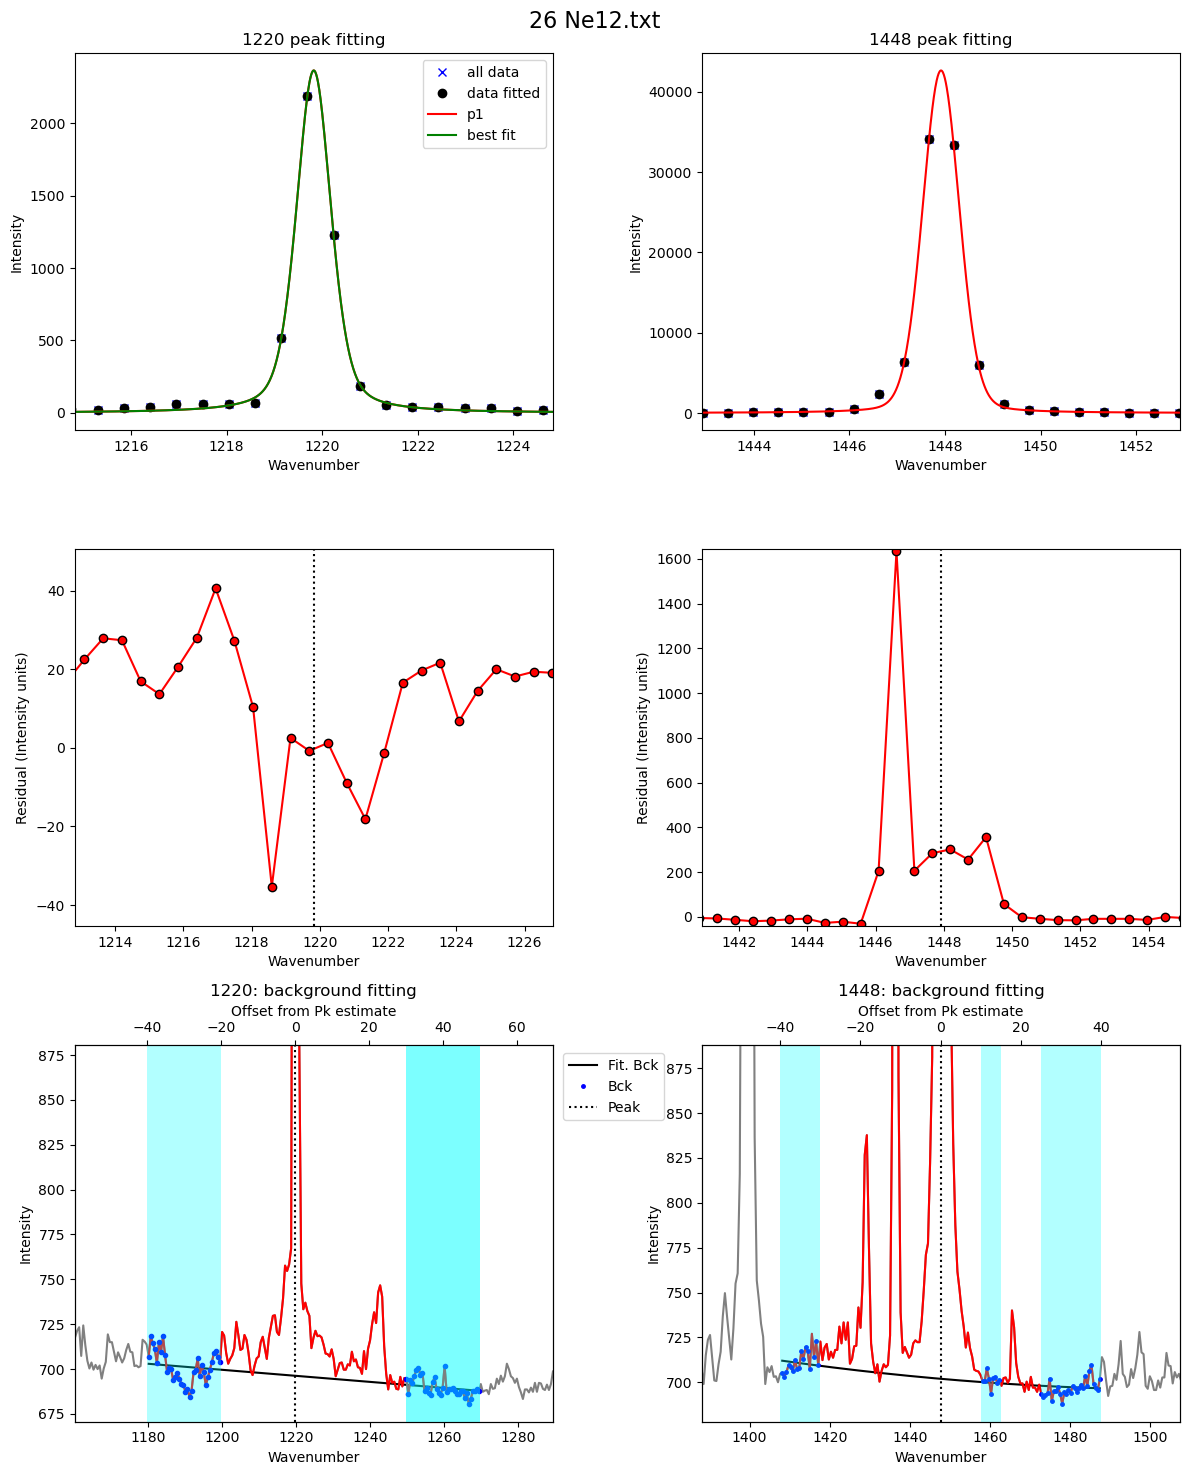

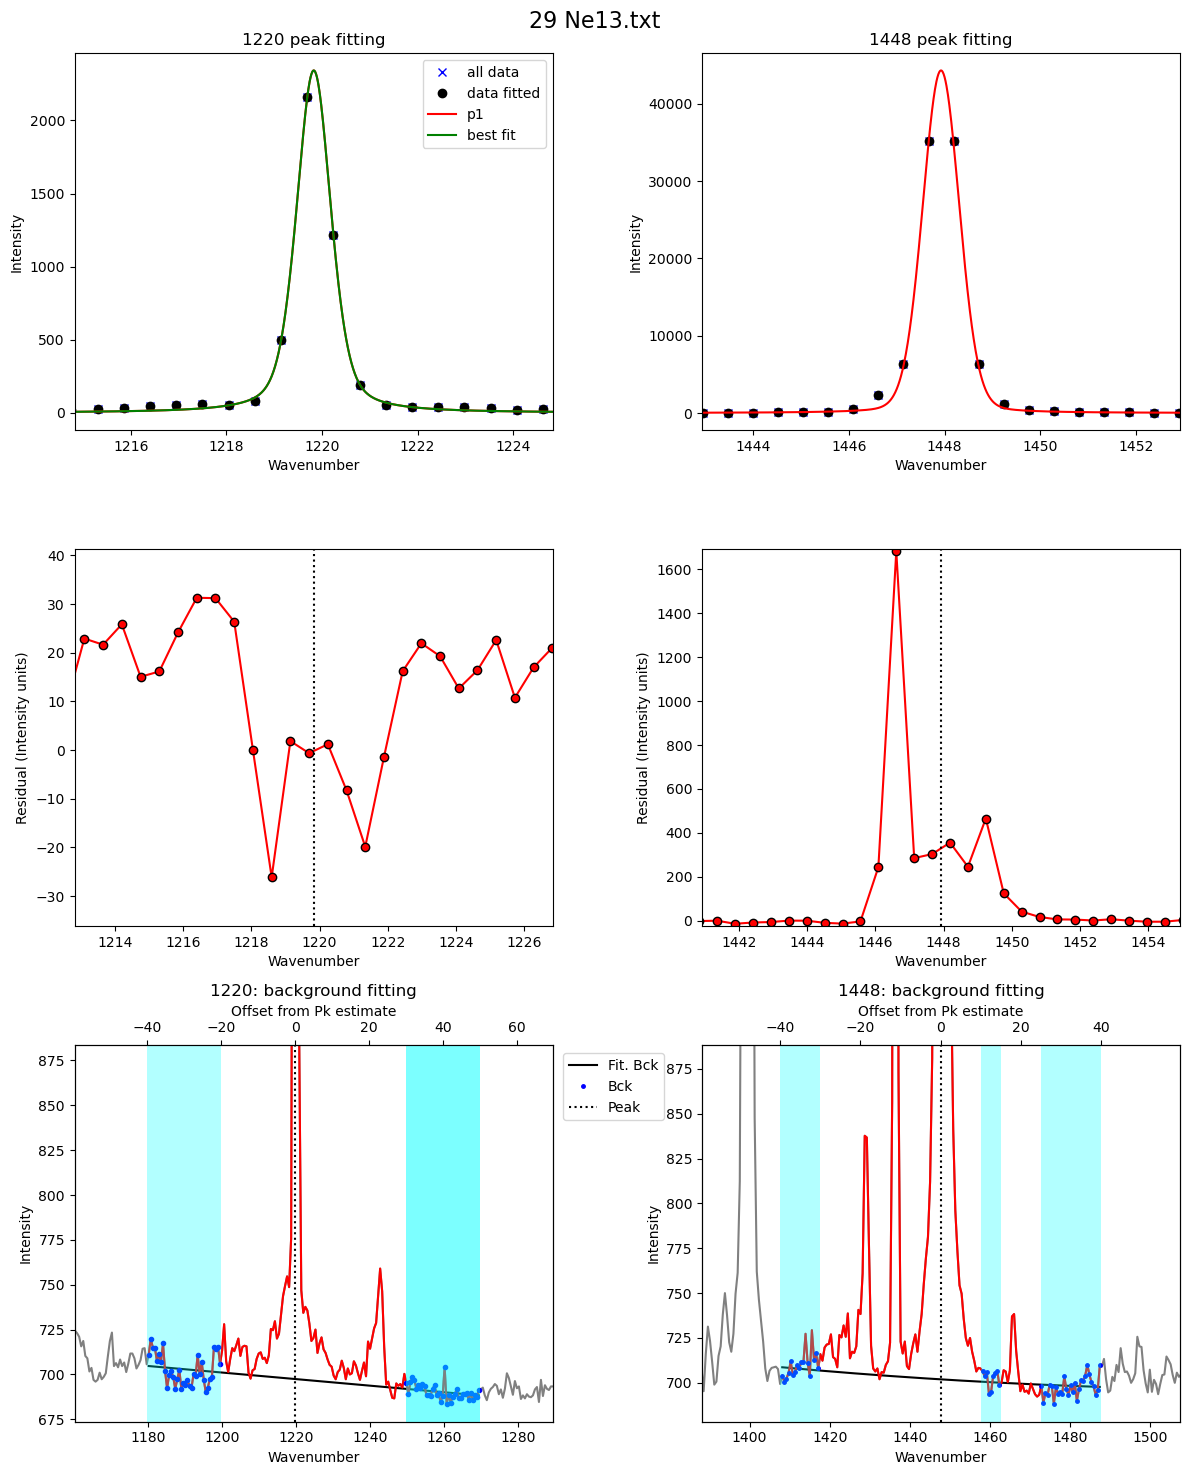

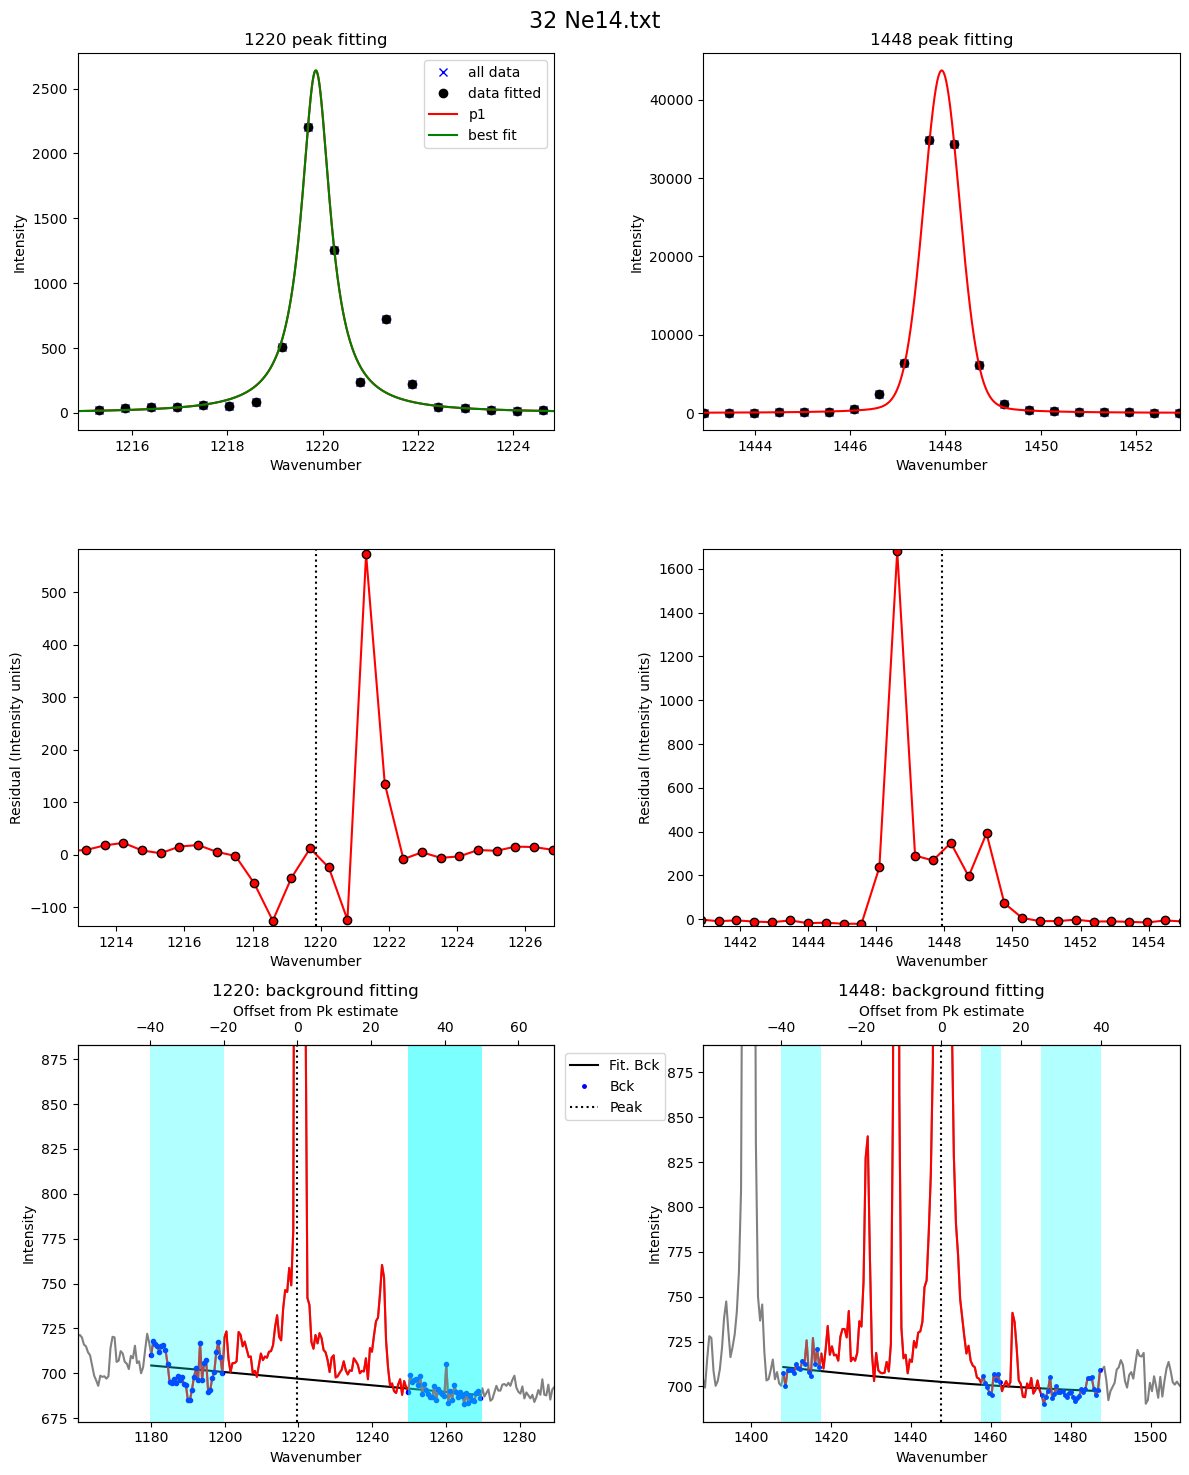

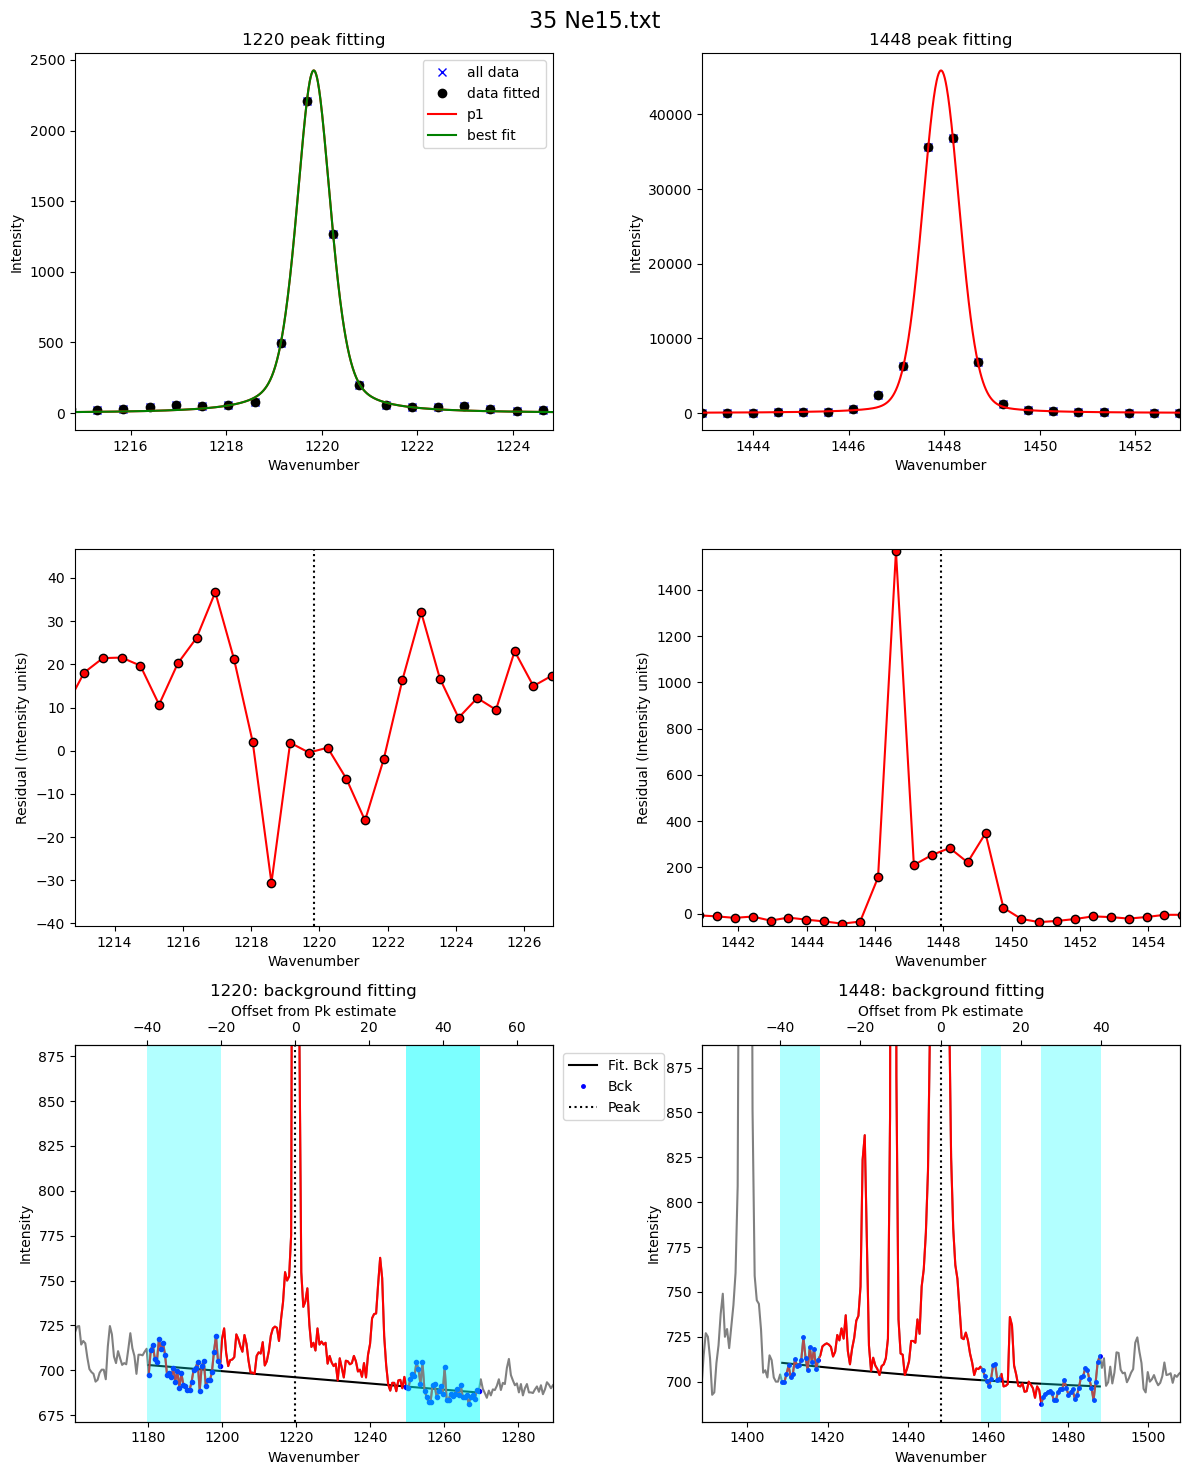

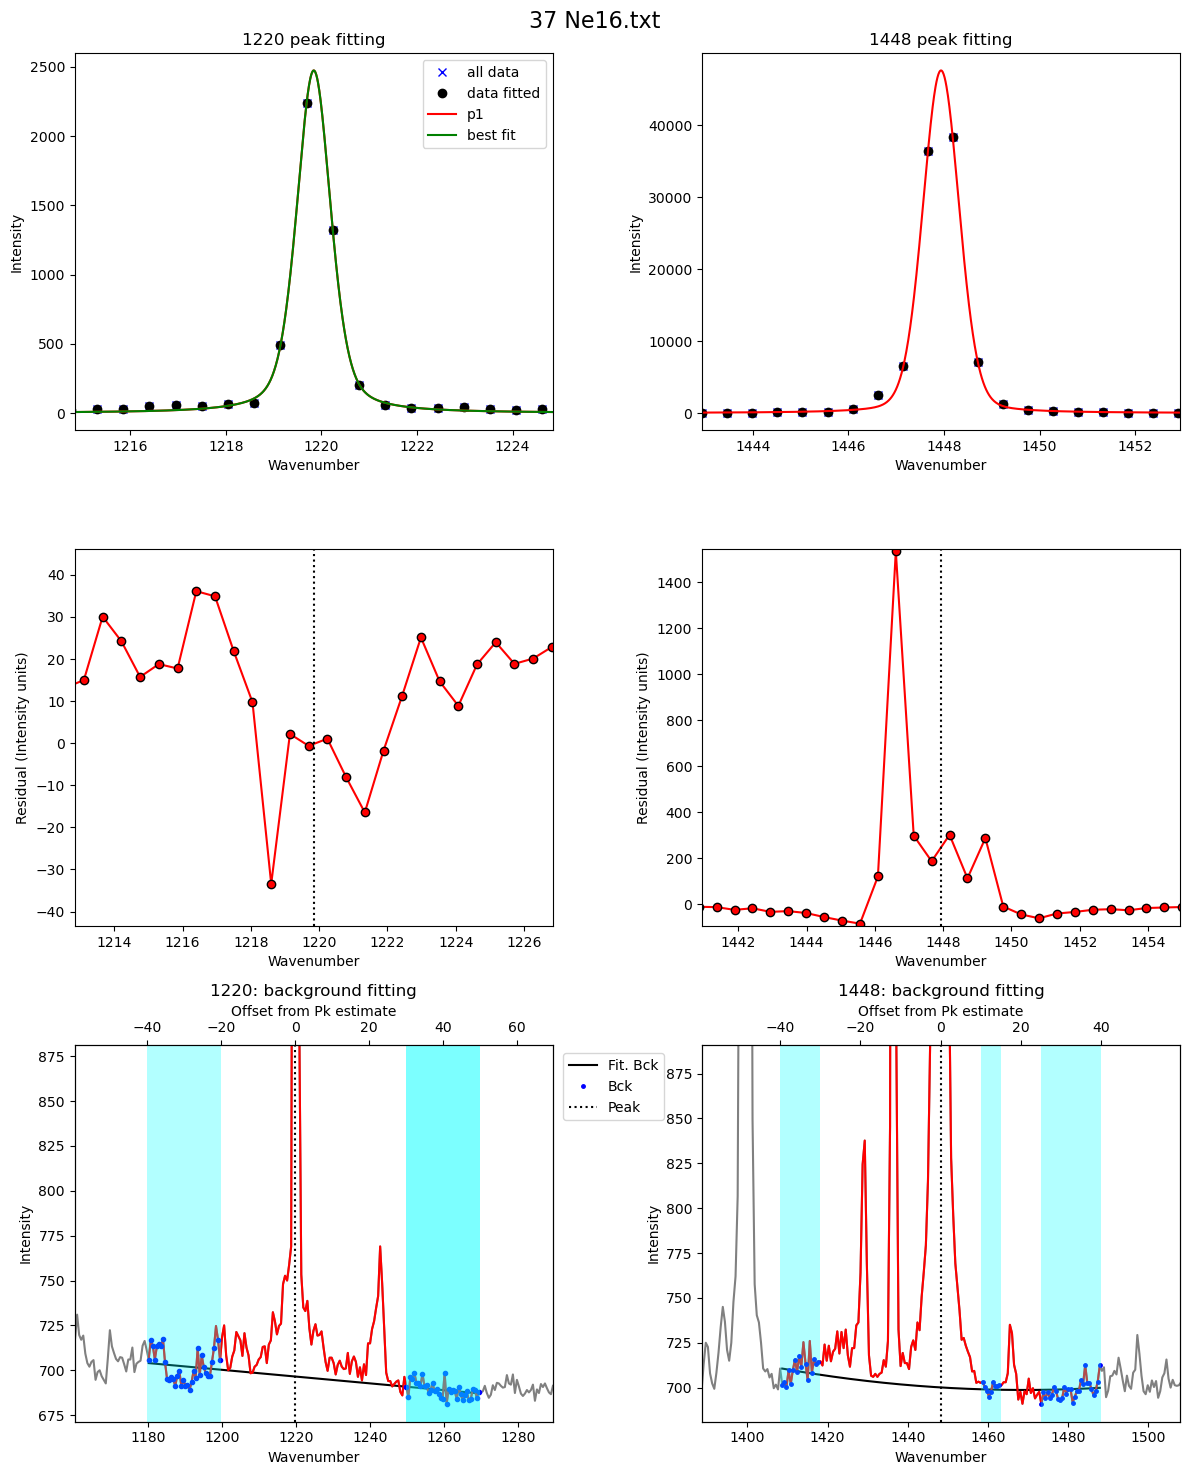

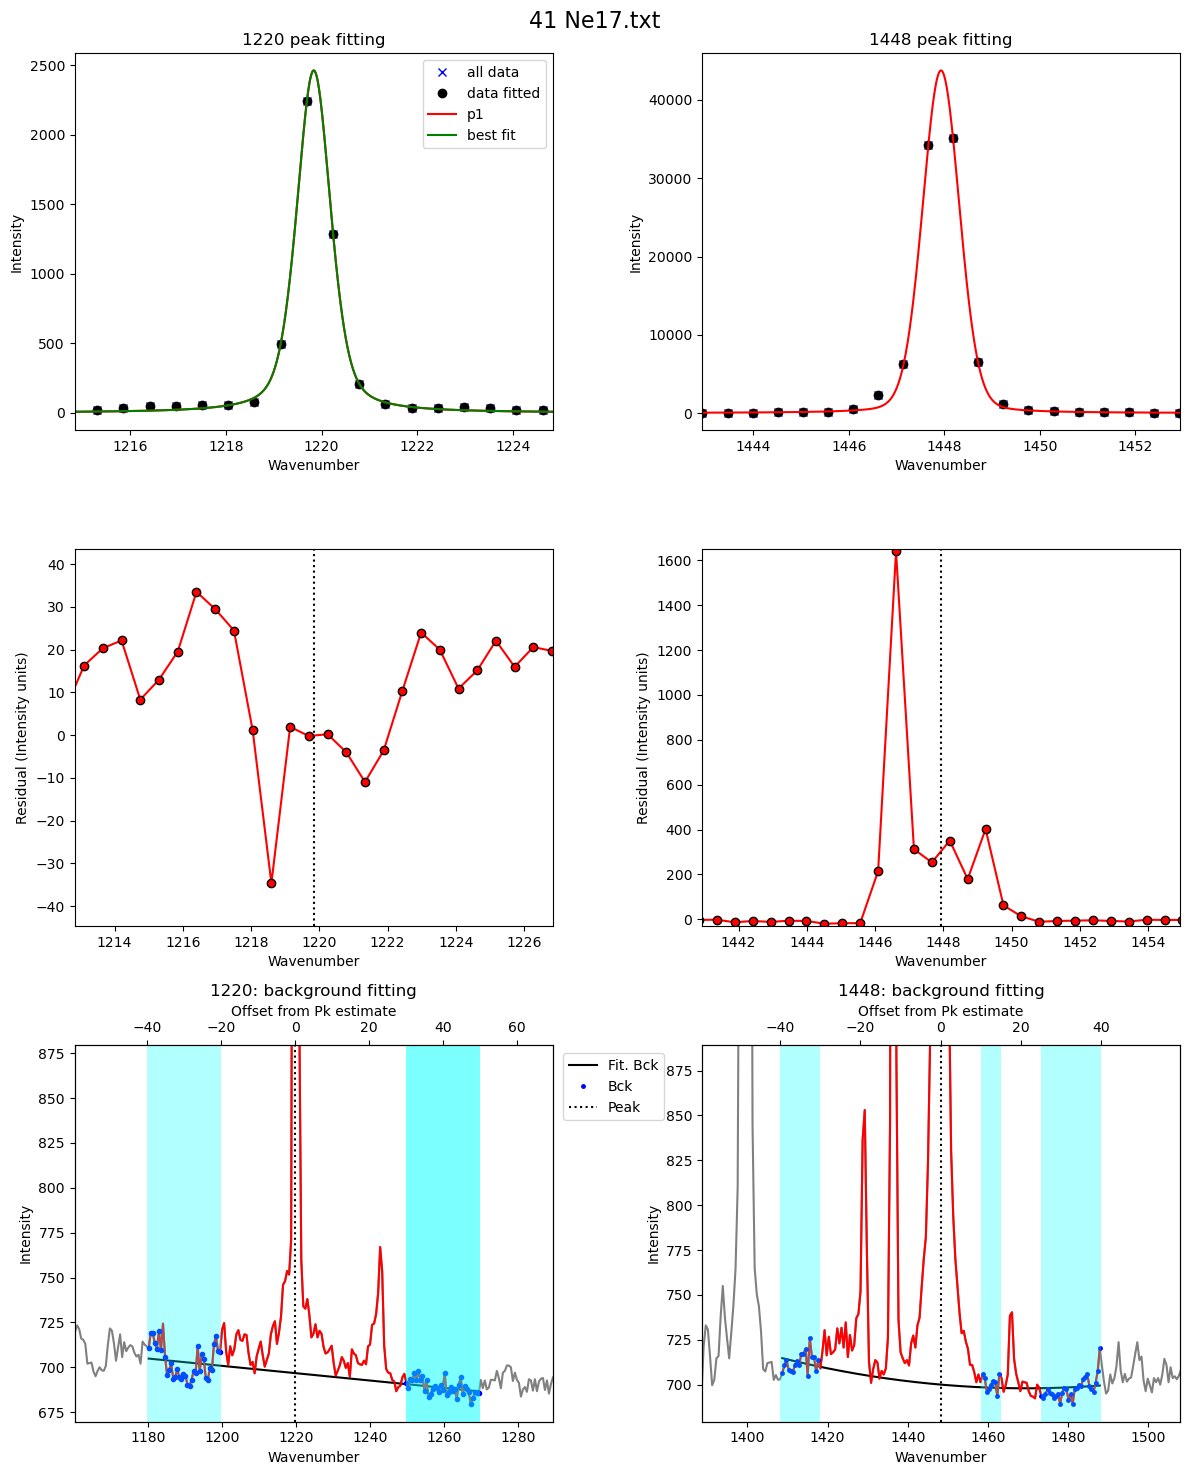

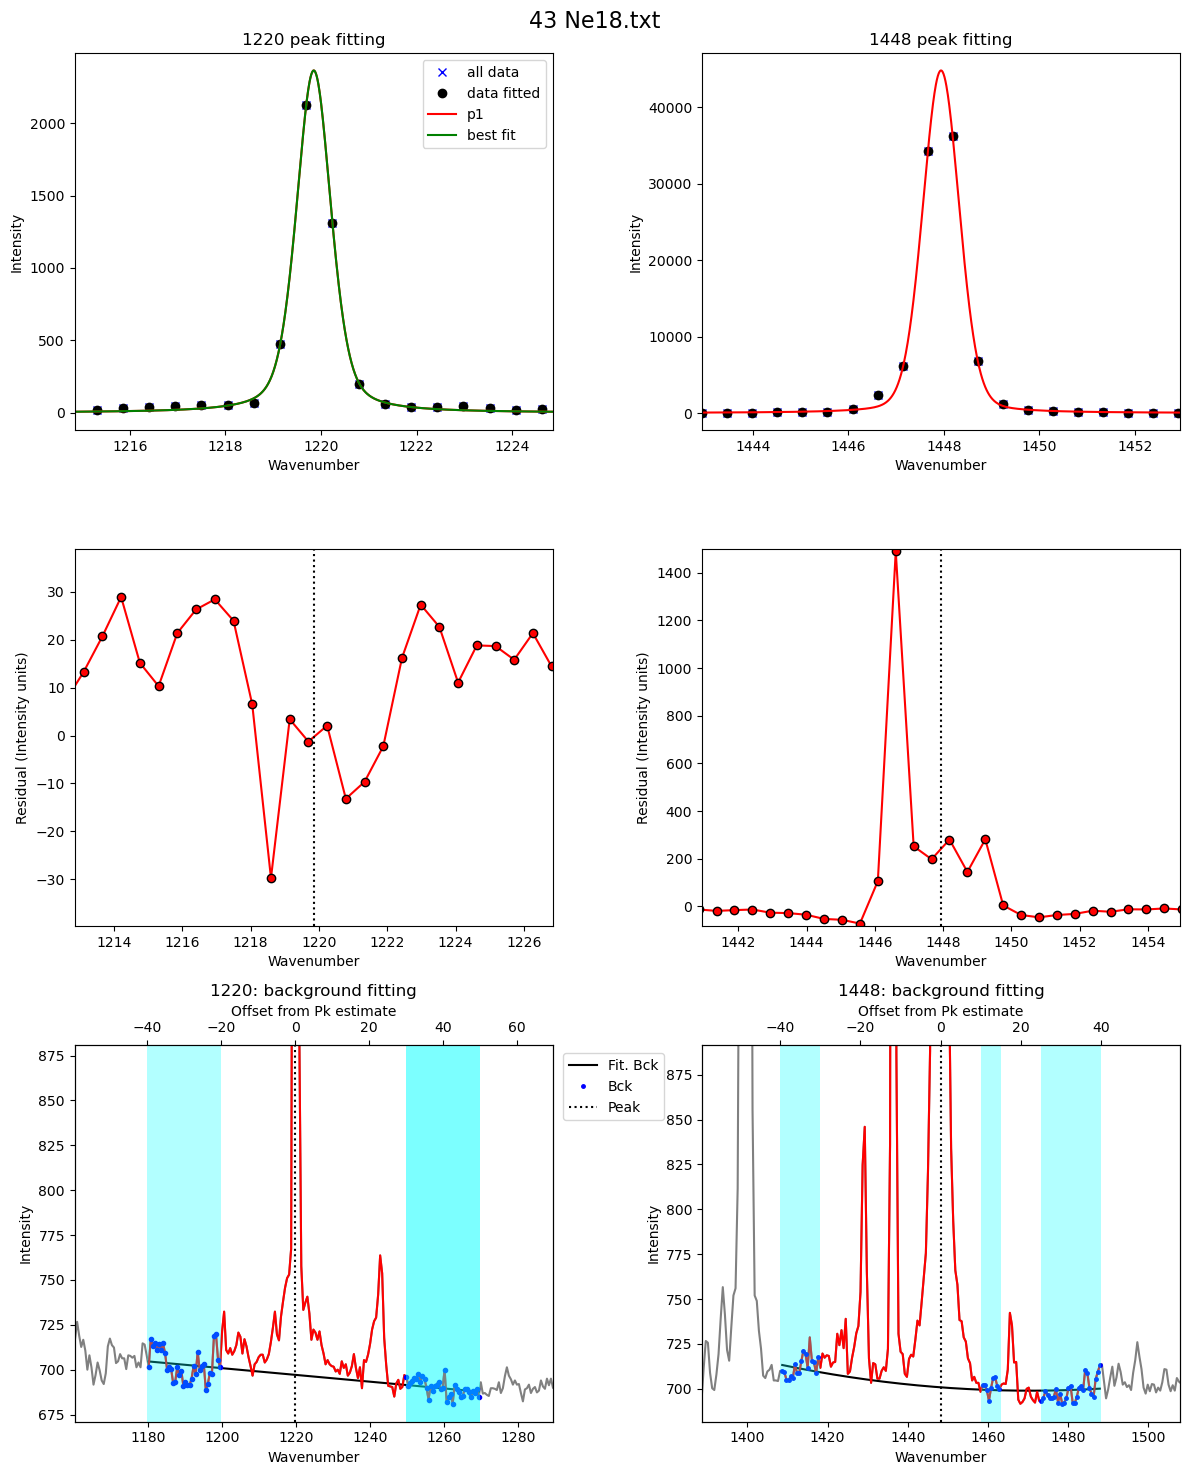

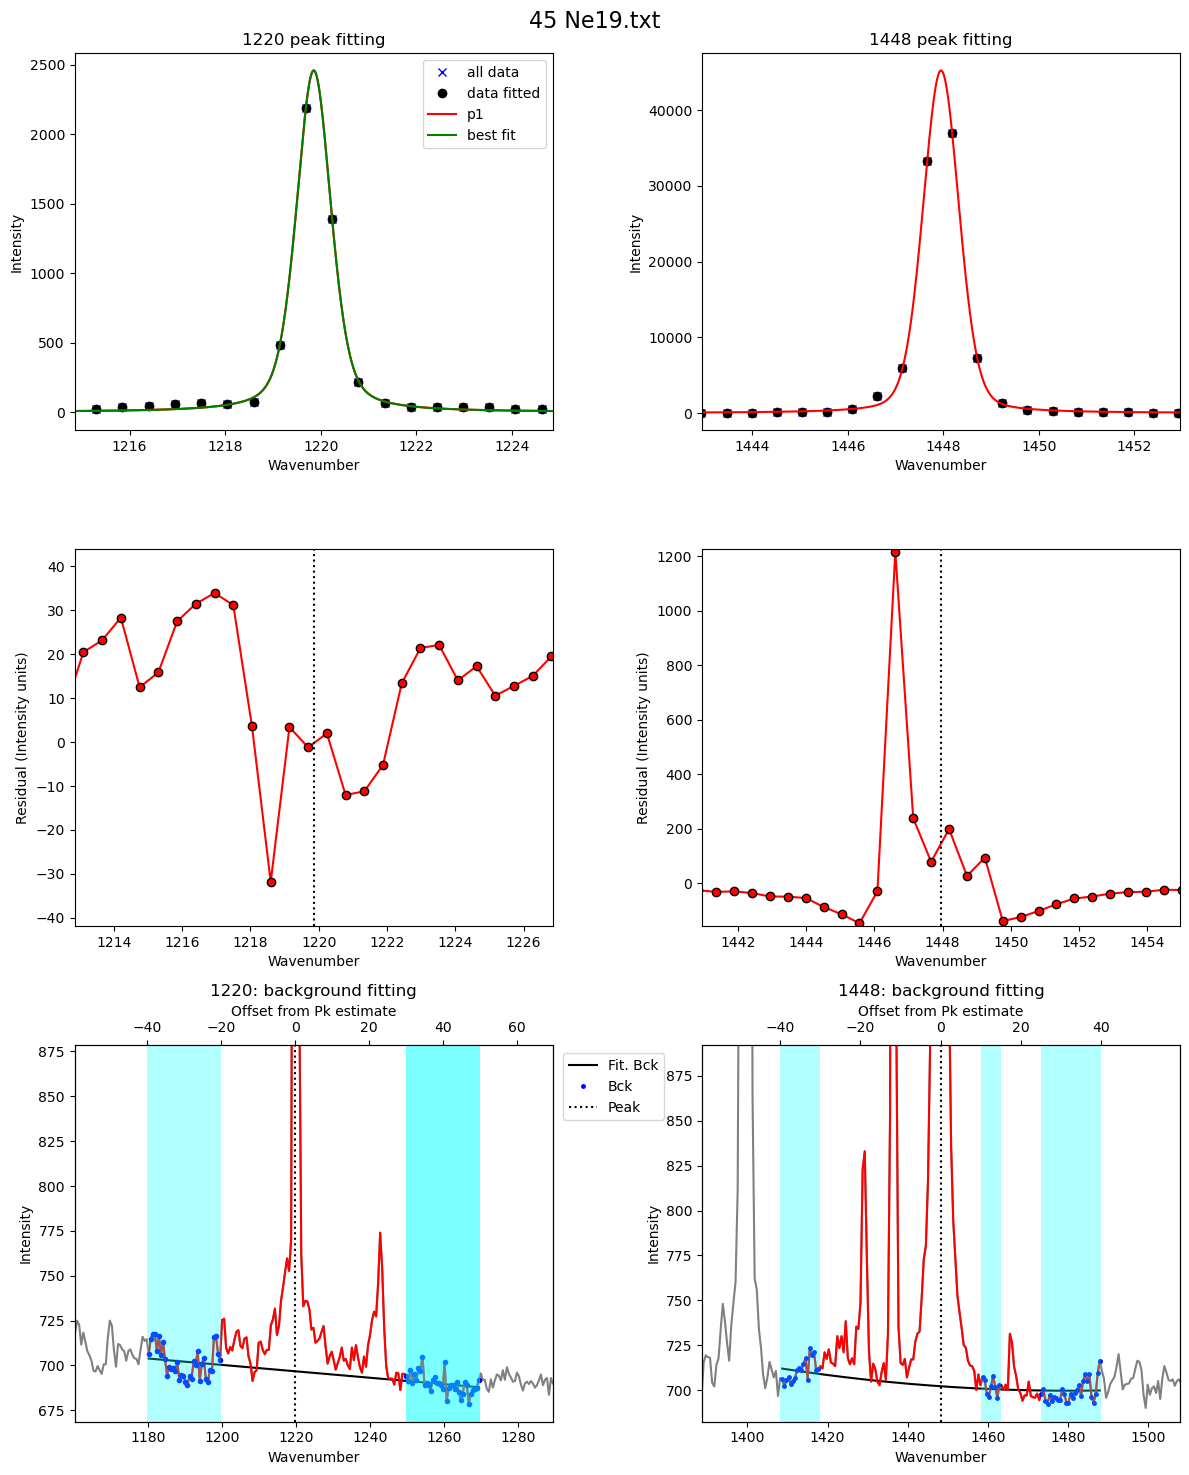

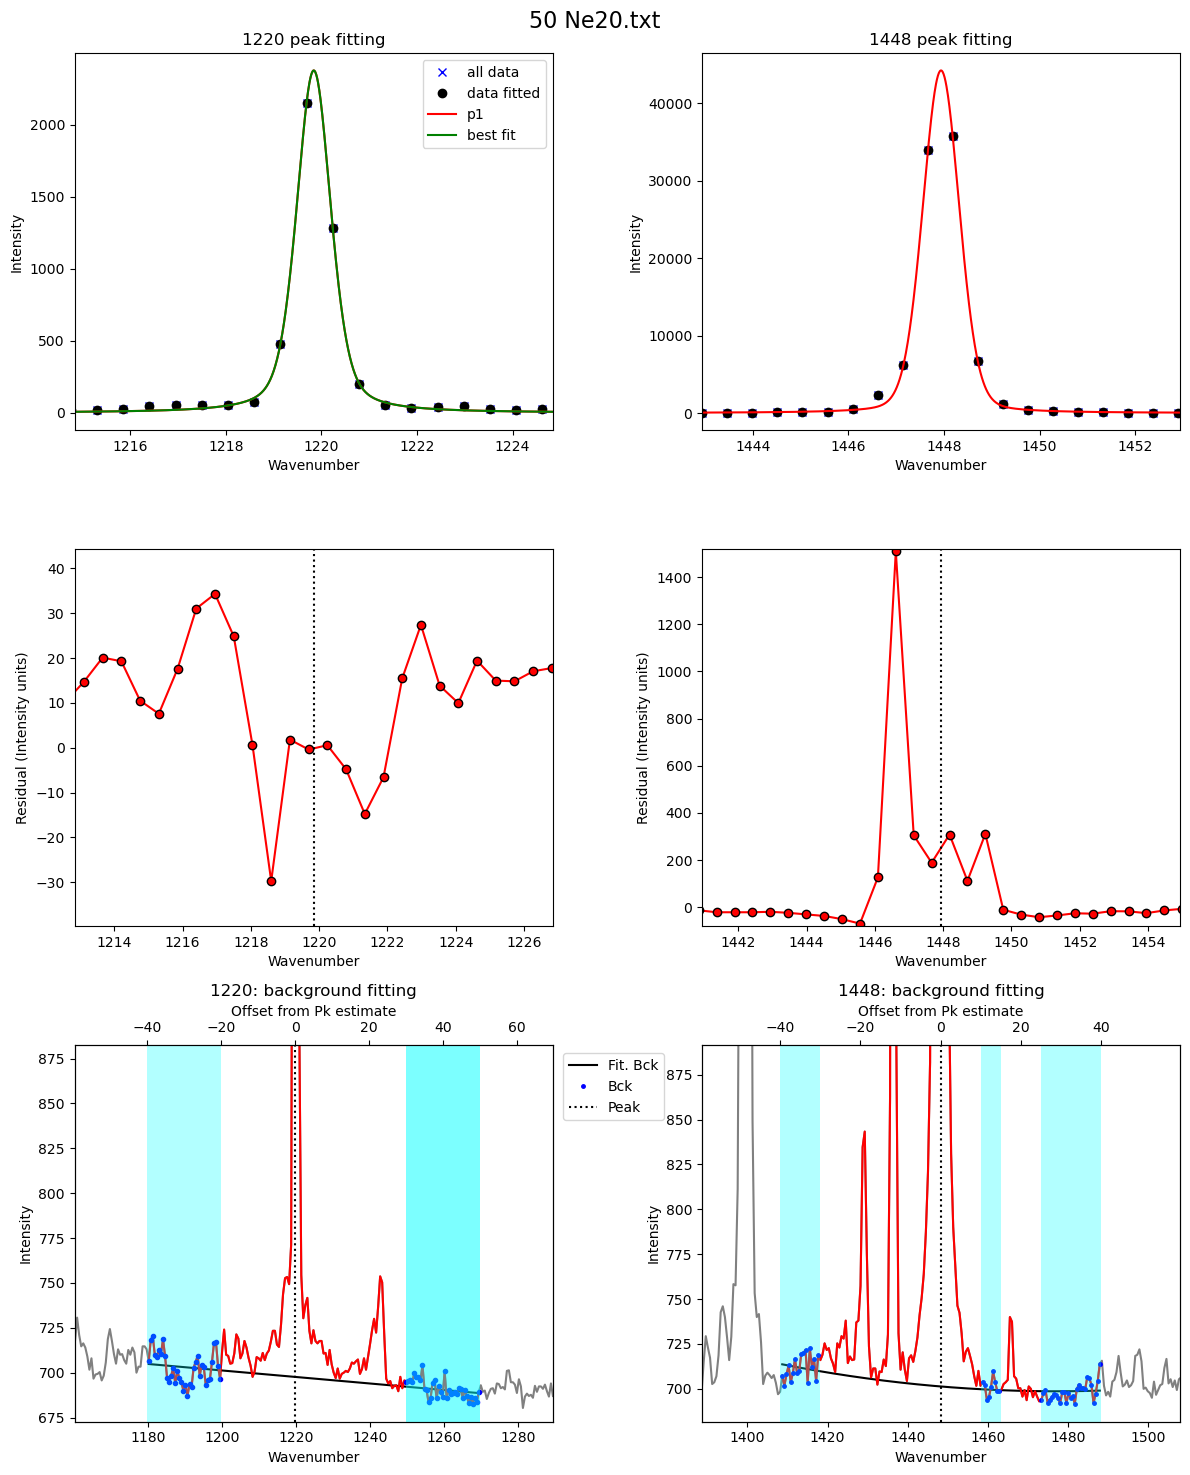

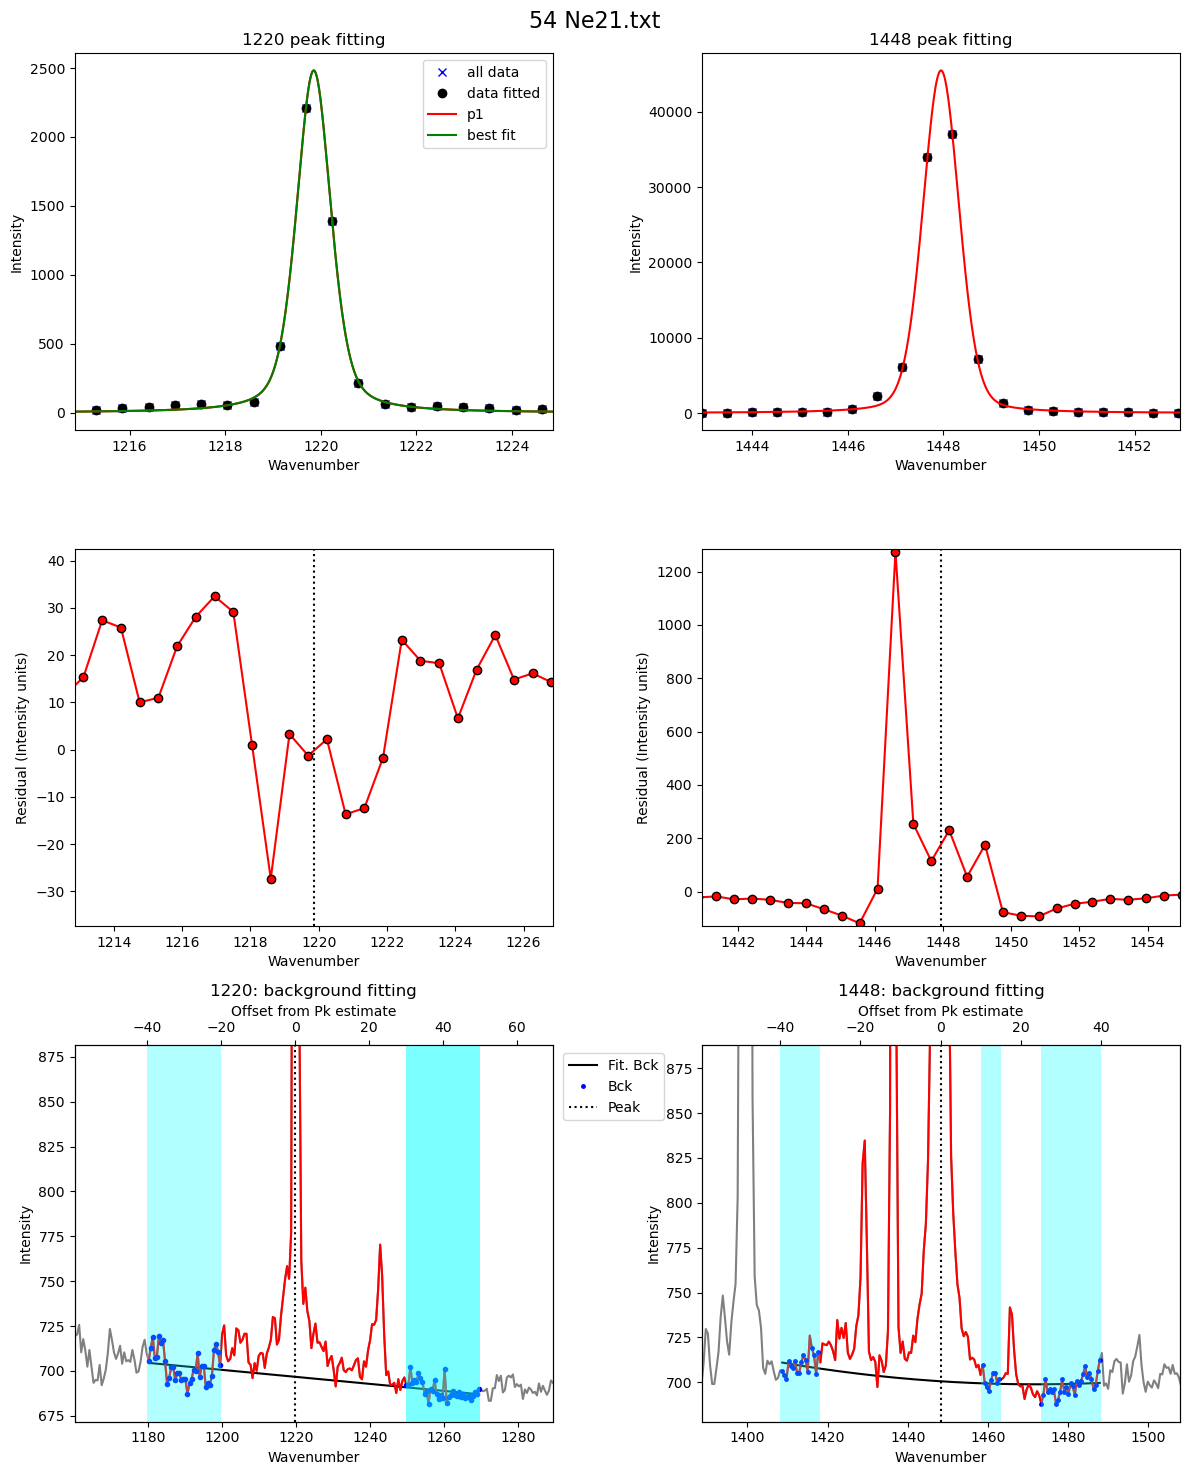

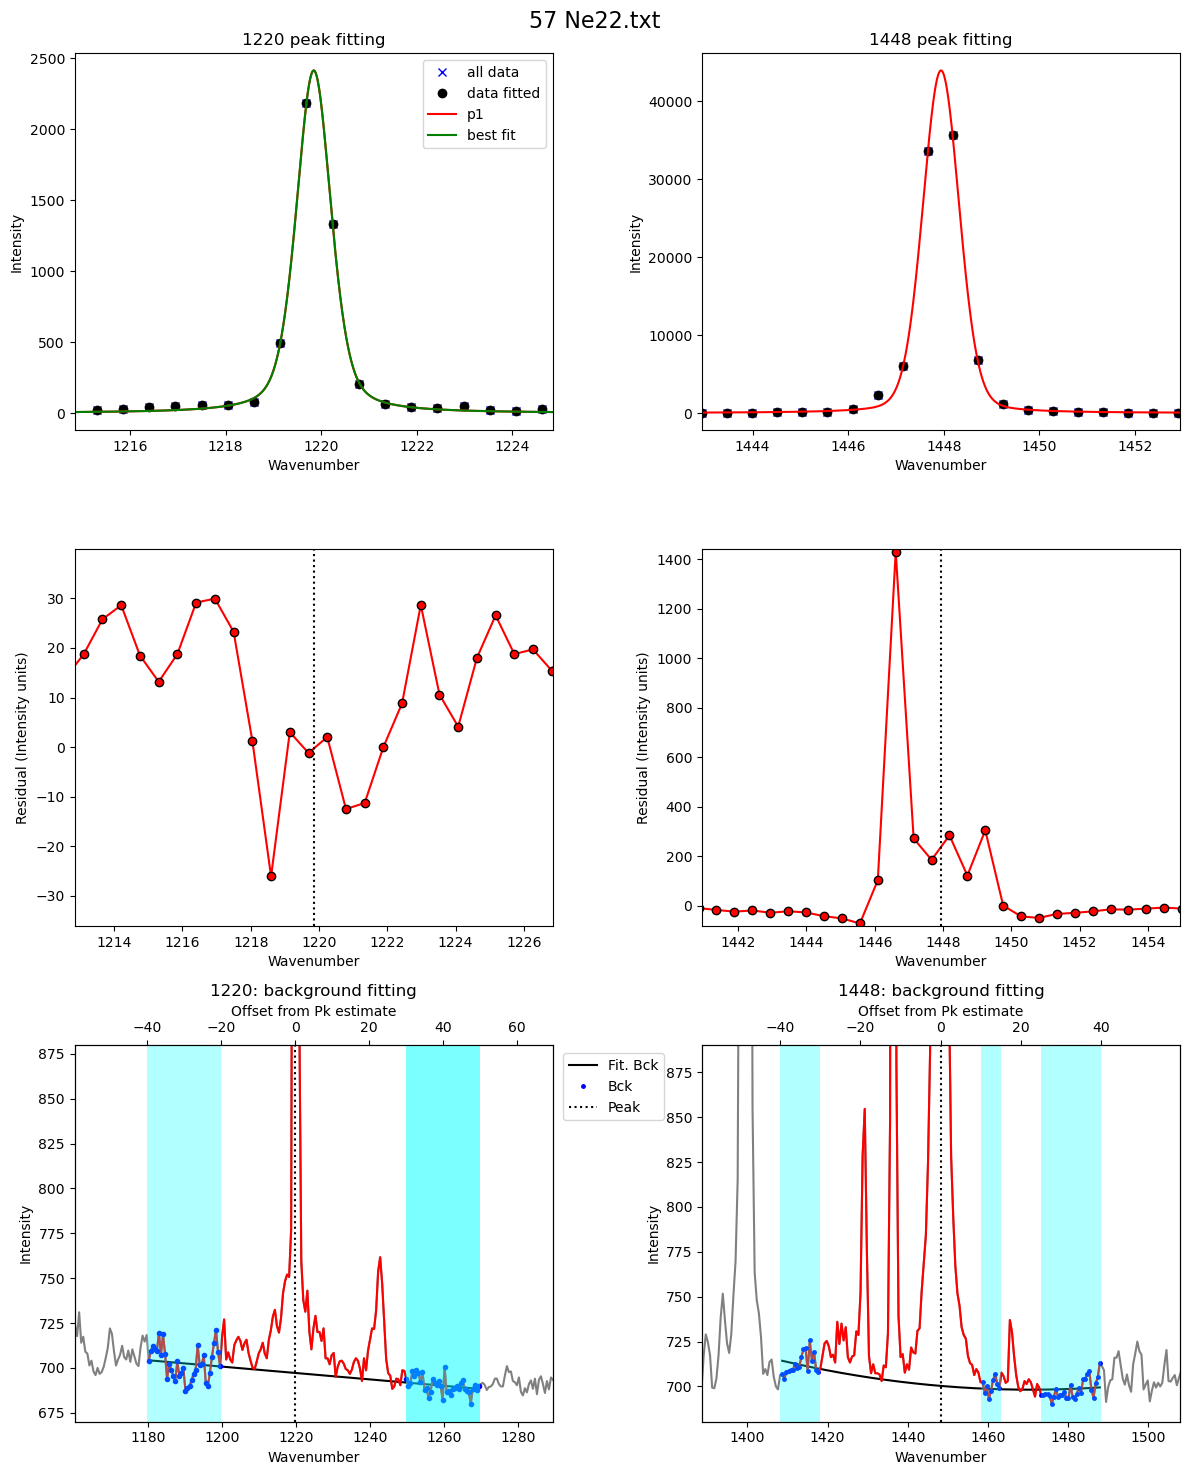

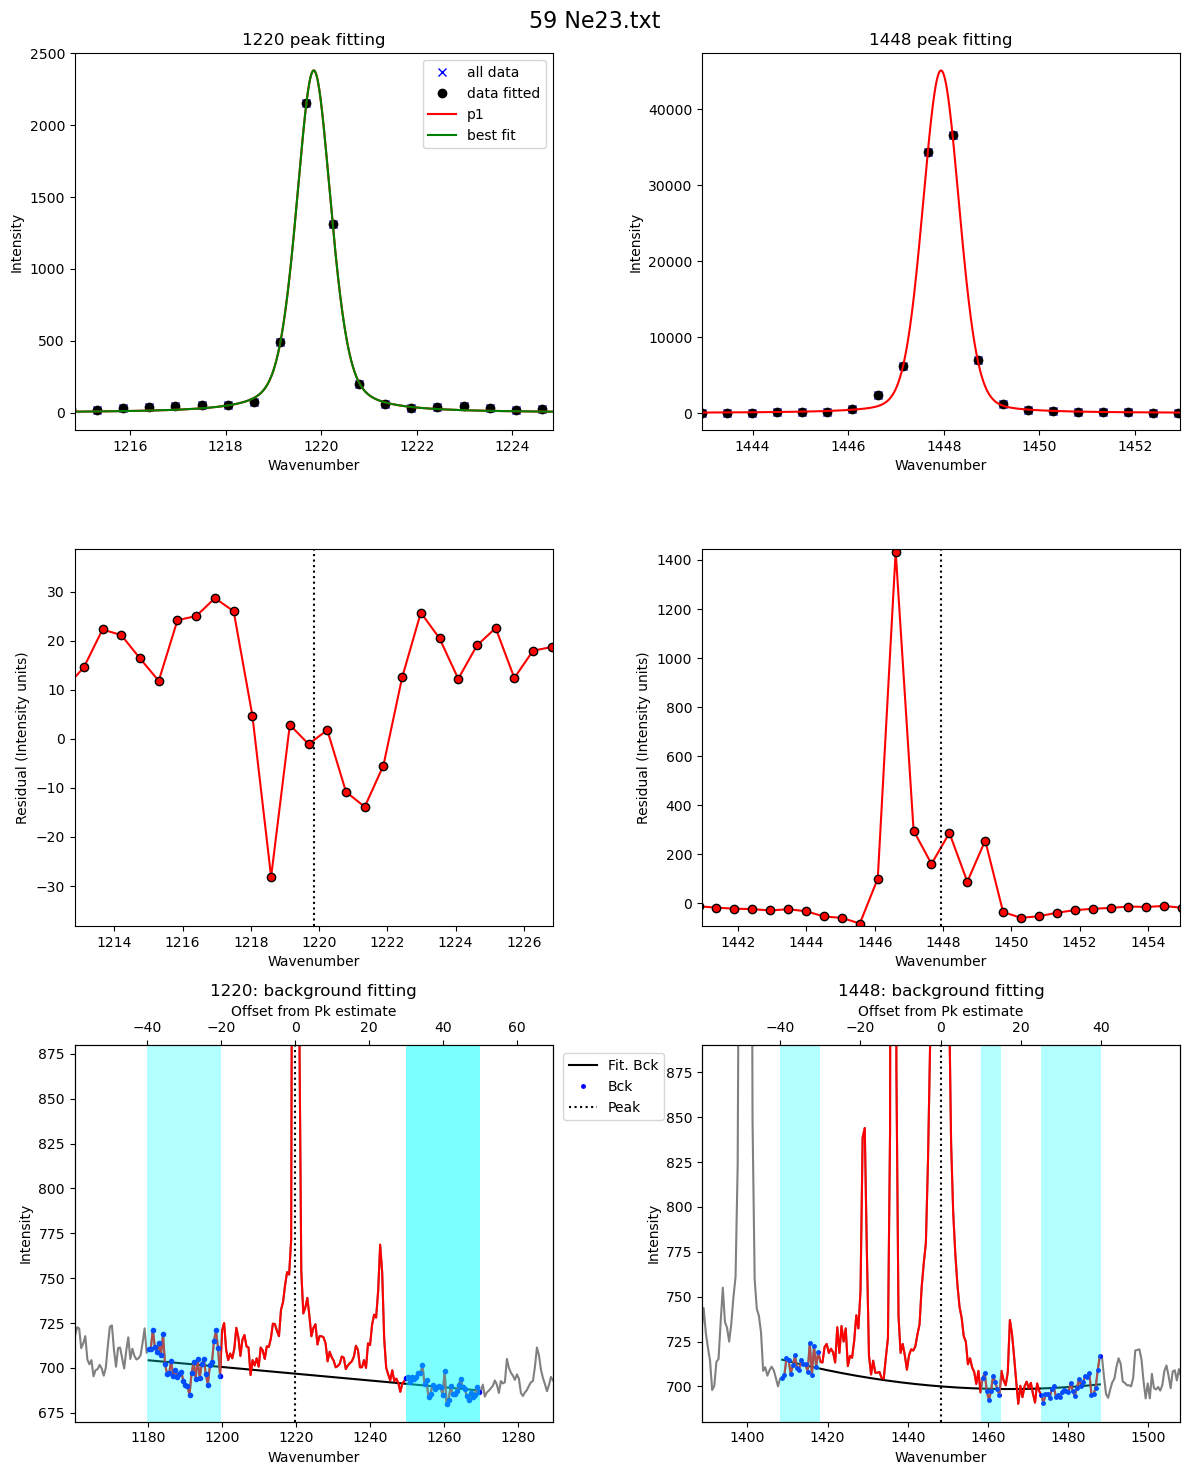

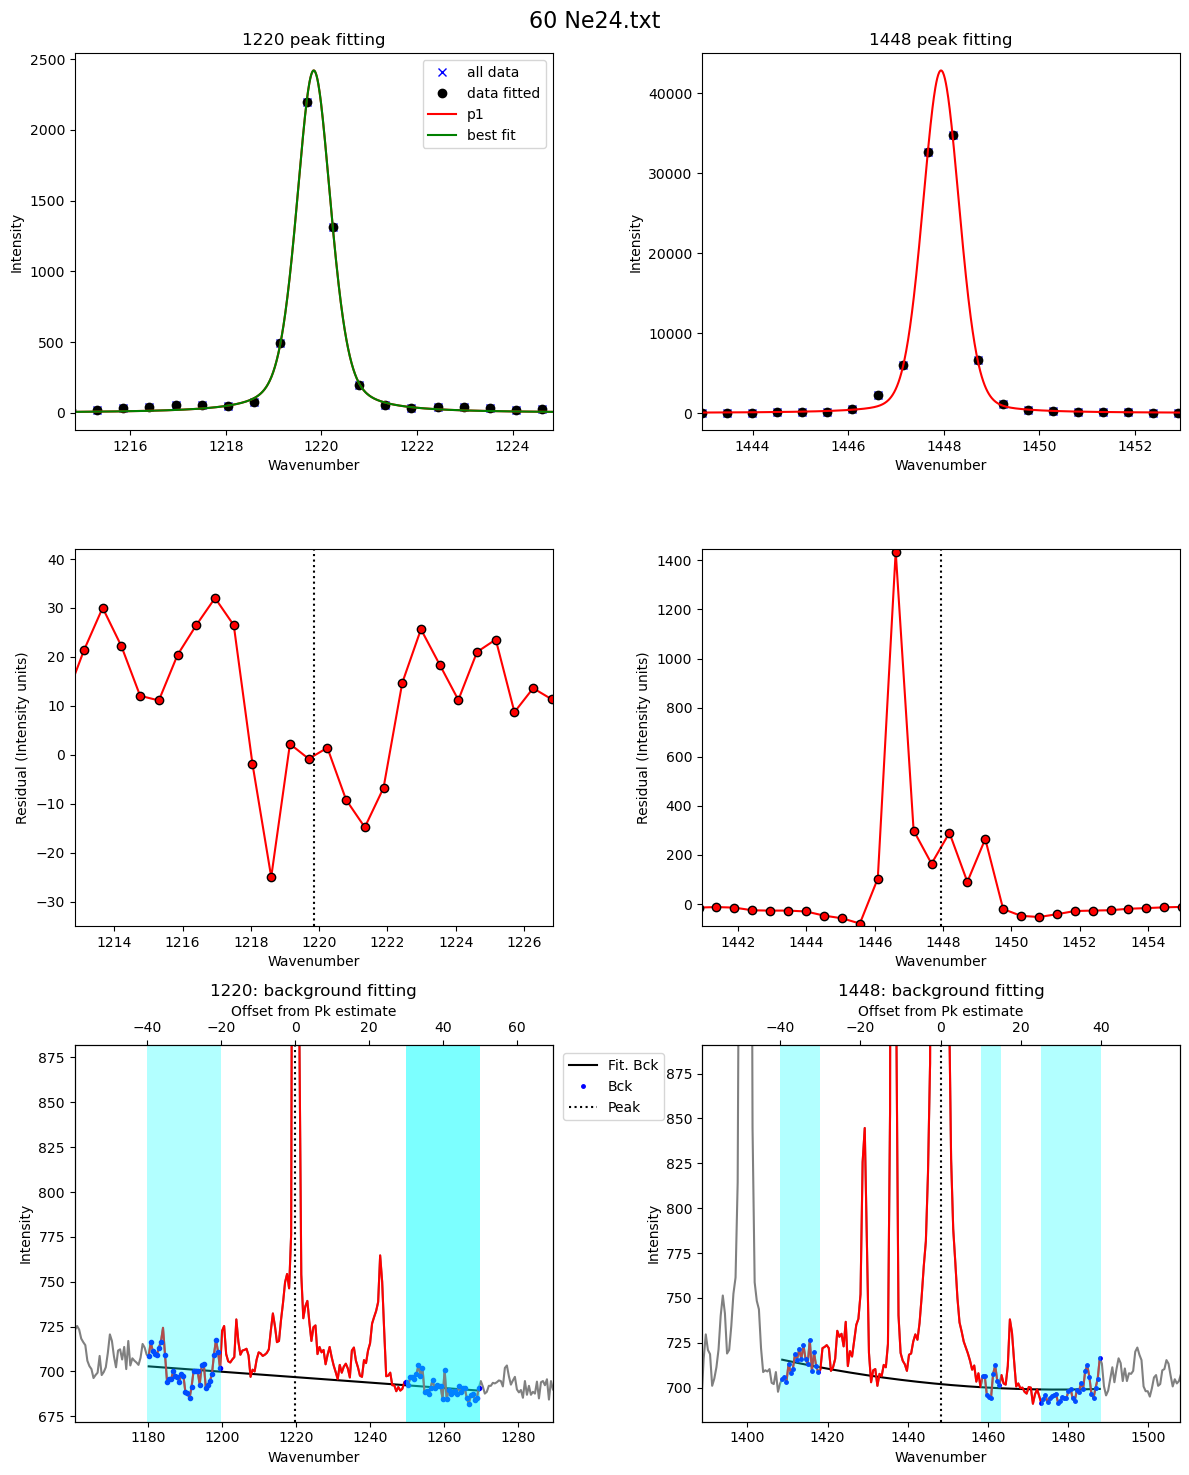

In [13]:
df2=pf.loop_Ne_lines(files=Ne_files, spectra_path=spectra_path, 
filetype=filetype, config_ID_peaks=Neon_id_config, config=Ne_Config_est,
df_fit_params=df_fit_params,  prefix=prefix,                   
plot_figure=True, const_params=True)


In [14]:
df2

filename   Ne_Corr  1σ_Ne_Corr     deltaNe  pk2_peak_cent  pk1_peak_cent  \
0    Ne1.txt  0.997235    0.000020  228.087794    1447.883402    1219.795607   
1    Ne2.txt  0.997250    0.000019  228.084334    1447.888875    1219.804541   
2    Ne3.txt  0.997228    0.000020  228.089493    1447.890859    1219.801366   
3    Ne4.txt  0.997237    0.000019  228.087469    1447.892996    1219.805527   
4    Ne5.txt  0.997240    0.000020  228.086592    1447.899377    1219.812785   
5    Ne6.txt  0.997230    0.000021  228.088911    1447.903636    1219.814725   
6    Ne7.txt  0.997229    0.000020  228.089101    1447.907531    1219.818431   
7    Ne8.txt  0.997223    0.000023  228.090589    1447.921388    1219.830799   
8    Ne9.txt  0.997210    0.000022  228.093567    1447.922646    1219.829079   
9   Ne10.txt  0.997214    0.000021  228.092595    1447.919176    1219.826581   
10  Ne11.txt  0.997335    0.000086  228.064997    1447.912797    1219.847800   
11  Ne12.txt  0.997203    0.000022  228.095084    1447.918503    1219.823419   
12  Ne13.txt  0.997194    0.000022  228.097203    1447.924350    1219.827147   
13  Ne14.txt  0.997348    0.000122  228.061979    1447.920752    1219.858773   
14  Ne15.txt  0.997181    0.000022  228.100219    1447.933915    1219.833697   
15  Ne16.txt  0.997192    0.000021  228.097585    1447.938094    1219.840509   
16  Ne17.txt  0.997196    0.000022  228.096670    1447.931667    1219.834997   
17  Ne18.txt  0.997215    0.000021  228.092357    1447.939944    1219.847588   
18  Ne19.txt  0.997192    0.000020  228.097767    1447.952550    1219.854783   
19  Ne20.txt  0.997193    0.000020  228.097439    1447.938126    1219.840687   
20  Ne21.txt  0.997206    0.000020  228.094450    1447.948328    1219.853878   
21  Ne22.txt  0.997200    0.000020  228.095892    1447.940581    1219.844688   
22  Ne23.txt  0.997187    0.000021  228.098838    1447.942227    1219.843389   
23  Ne24.txt  0.997176    0.000021  228.101223    1447.941454    1219.840231   

    pk2_amplitude  pk1_amplitude  residual_pk2  residual_pk1  ...  pk2_gamma  \
0    46437.292356    2608.645230    109.968031     15.820977  ...       None   
1    45850.635610    2546.793650    106.094325     14.702195  ...       None   
2    45908.119669    2594.301767    101.328614     15.586160  ...       None   
3    45343.893590    2531.433916     94.915695     15.088689  ...       None   
4    47298.891058    2598.451104     88.463376     14.681107  ...       None   
5    46781.929062    2563.388568     86.448304     15.983445  ...       None   
6    46569.014639    2503.708521     88.154322     15.212606  ...       None   
7    46182.781474    2547.837001     97.136960     16.498550  ...       None   
8    44417.282678    2555.541054     94.201893     15.112168  ...       None   
9    46696.338425    2669.267055     94.278273     15.364041  ...       None   
10   44431.762665    3222.169675     87.834276     37.305460  ...       None   
11   43629.067215    2564.139750     93.494310     16.644418  ...       None   
12   44969.588774    2526.231979    100.475518     15.080288  ...       None   
13   44613.591363    3063.963284     97.045444     40.127347  ...       None   
14   46949.279493    2609.260475     92.604753     14.387476  ...       None   
15   48887.667790    2643.723078     93.010075     15.801889  ...       None   
16   44902.303900    2639.179879     93.998357     13.754917  ...       None   
17   46256.026232    2553.102238     88.727581     14.217262  ...       None   
18   47279.299447    2668.562568     87.061849     15.682429  ...       None   
19   45627.070411    2560.521191     90.542141     13.570487  ...       None   
20   47345.732632    2687.149111     83.233005     14.448983  ...       None   
21   45432.039223    2630.035150     86.375799     14.900758  ...       None   
22   46758.506601    2587.980334     87.451411     14.703934  ...       None   
23   44397.696060    2613.188345     87.416030     14.660506  ...       None   

  

## Now extract metadata to get a timestamp for each file

In [15]:
## Get meta files
Ne_files_meta=pf.get_files(path=meta_path,
file_ext='txt', ID_str='Ne', 
exclude_str=['diad'], sort=False)

Ne_files_meta[0:5]

['01 Ne1.txt', '02 Ne2.txt', '03 Ne3.txt', '04 Ne4.txt', '05 Ne5.txt']

In [16]:
# This cell stitches metadata together - e.g. gets your laser power, time stamp, accumulations etc
meta=pf.stitch_metadata_in_loop_witec(path=meta_path, 
Allfiles=Ne_files_meta, prefix=prefix, trupower=TruPower)
meta.head()

100%|██████████| 24/24 [00:00<00:00, 197.76it/s]

Done


filename            date Month  Day  power (mW)  Int_time (s)  \
0  Ne1.txt  June 8, 2023\n  June  8.0      34.430          45.0   
1  Ne2.txt  June 8, 2023\n  June  8.0      34.438          45.0   
2  Ne3.txt  June 8, 2023\n  June  8.0      34.495          45.0   
3  Ne4.txt  June 8, 2023\n  June  8.0      34.506          45.0   
4  Ne5.txt  June 8, 2023\n  June  8.0      34.477          45.0   

   accumulations  Mag (X)             duration      24hr_time  \
0            3.0      5.0  ['0h', '2m', '19s']  12:01:31 PM\n   
1            3.0      5.0  ['0h', '2m', '16s']  12:05:23 PM\n   
2            3.0      5.0  ['0h', '2m', '16s']  12:09:28 PM\n   
3            3.0      5.0  ['0h', '2m', '16s']  12:12:54 PM\n   
4            3.0      5.0  ['0h', '2m', '16s']  12:23:40 PM\n   

   sec since midnight  Spectral Center  
0             43291.0         1325.004  
1             43523.0         1325.004  
2             43768.0         1325.004  
3             43974.0         1325.004  
4             44620.0         1325.004

In [17]:
# This is getting the metadata file names.  Check here the prefix has been removed. 
file_m=pf.extracting_filenames_generic(names=meta['filename'], 
   file_ext='.txt')
file_m

good job, no duplicate file names


array(['Ne1', 'Ne2', 'Ne3', 'Ne4', 'Ne5', 'Ne6', 'Ne7', 'Ne8', 'Ne9',
       'Ne10', 'Ne11', 'Ne12', 'Ne13', 'Ne14', 'Ne15', 'Ne16', 'Ne17',
       'Ne18', 'Ne19', 'Ne20', 'Ne21', 'Ne22', 'Ne23', 'Ne24'],
      dtype=object)

In [18]:
# This is getting the spectra file names. Check that they are in the same format as the metadataones above, this is what you need to successfully stitch together. 
file_s=pf.extracting_filenames_generic(names=df2['filename'],
   file_ext='.txt')
file_s

good job, no duplicate file names


array(['Ne1', 'Ne2', 'Ne3', 'Ne4', 'Ne5', 'Ne6', 'Ne7', 'Ne8', 'Ne9',
       'Ne10', 'Ne11', 'Ne12', 'Ne13', 'Ne14', 'Ne15', 'Ne16', 'Ne17',
       'Ne18', 'Ne19', 'Ne20', 'Ne21', 'Ne22', 'Ne23', 'Ne24'],
      dtype=object)

## Combine 2 dataframes
- Here we add a new column to each dataframe with these stripped back names, and then merge the 2 dataframes

In [19]:
meta['name_for_matching']=file_m
df2['name_for_matching']=file_s
df_combo=df2.merge(meta, on='name_for_matching')

## Now lets inspect changes in Ne correction factor with time
- Normally, you can spot outliers this way

In [20]:
df_combo_sort=df_combo.sort_values(by='sec since midnight')
df_combo_sort.to_excel('PseudoVoigt.xlsx')

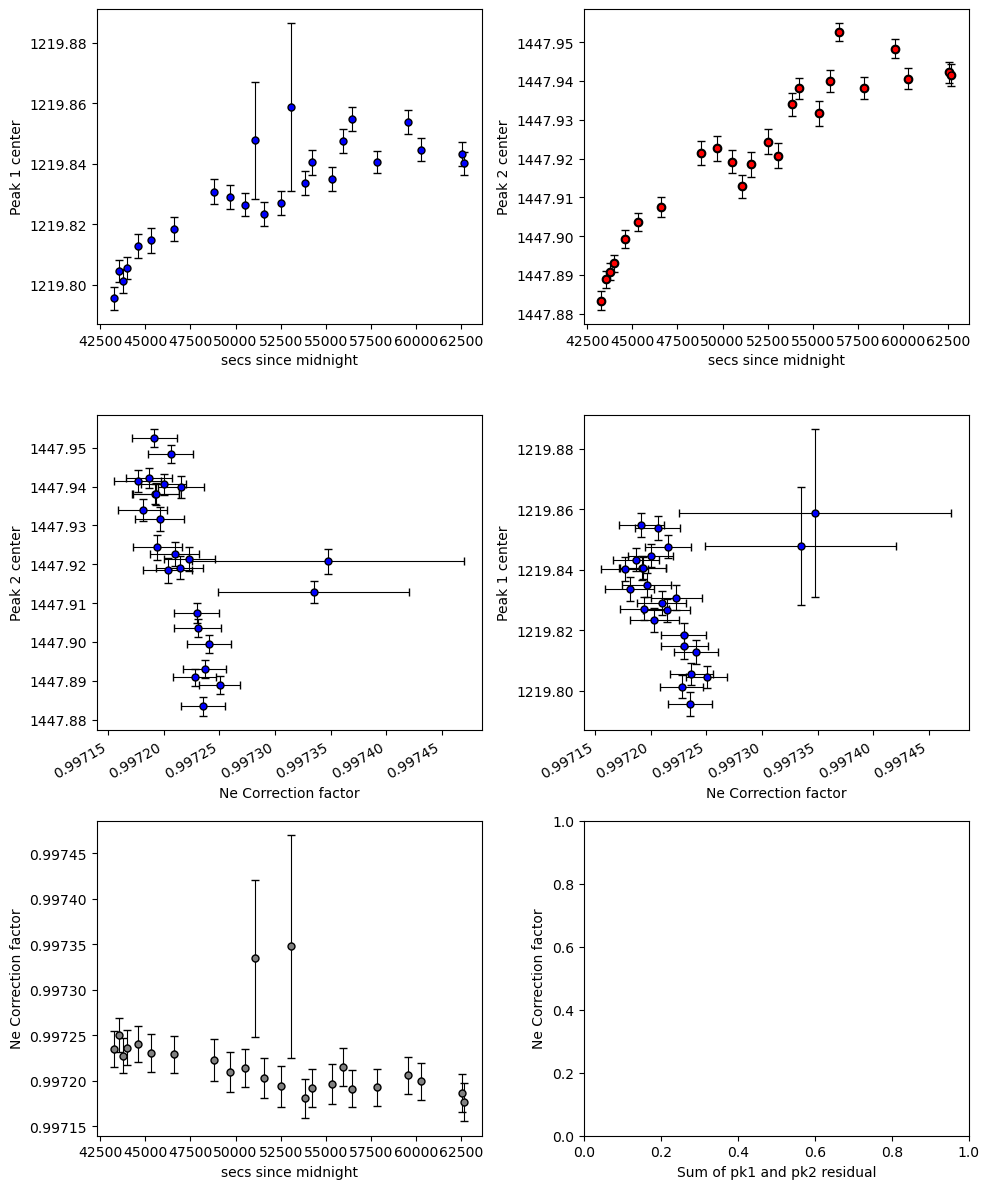

In [21]:
fig=pf.plot_Ne_corrections(df=df_combo, x_axis=df_combo['sec since midnight'],
                      x_label='secs since midnight')


## Exclude ones that don't look right...
- The filter_Ne_Line_neighbours excludes Ne lines that have a correction factor more than "offset" from their N neighbours (defined by "number_av")
- Tweak offset and number_av until you exclude the ones that dont look right
- Smaller number of offset - more discarded
- If you notice really bad fits, you can also exclude certain files like file_name_filt=['Ne_line_1.txt'], or file_name_filt=['Ne_line_2.txt', 'Ne_line_5.txt']

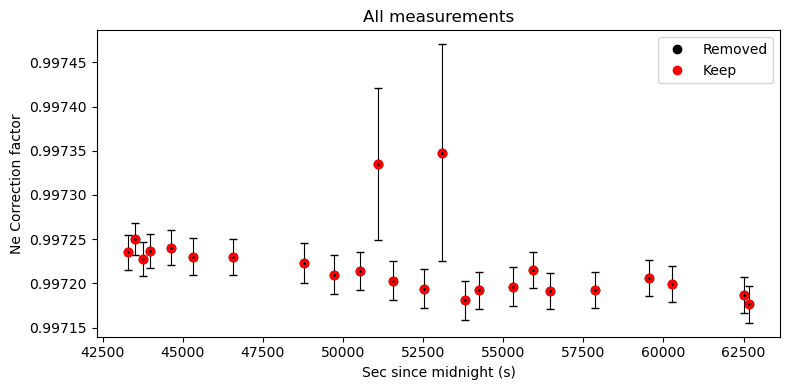

In [22]:
filt=pf.filter_Ne_Line_neighbours(df_combo=df_combo, 
                    number_av=3, offset=0.001, file_name_filt=None)
# Now lets plot this to see
fig, (ax1) = plt.subplots(1, 1, figsize=(8,4))
ax1.errorbar(df_combo['sec since midnight'], df_combo['Ne_Corr'], xerr=0, 
yerr=df_combo['1σ_Ne_Corr'], fmt='d', ecolor='k', elinewidth=0.8, mfc='cyan', ms=1, mec='k', capsize=3)
ax1.plot(df_combo['sec since midnight'], df_combo['Ne_Corr'],   'ok', label='Removed')
ax1.plot(df_combo['sec since midnight'], filt,  'or', label='Keep')

ax1.legend()

ax1.set_xlabel('Sec since midnight (s)')
ax1.set_ylabel('Ne Correction factor')
ax1.set_title('All measurements')

fig.tight_layout()

## Now lets make a regression against time
- We take this time regression and then apply to our diad fits

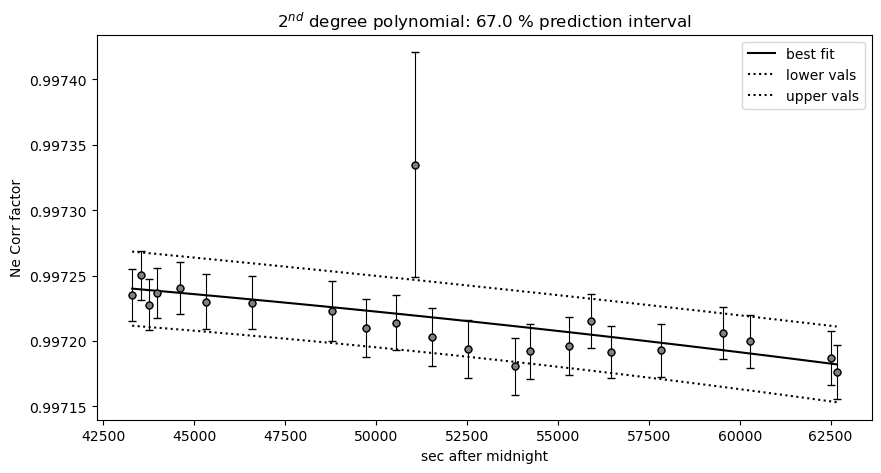

In [23]:

big_err=df_combo['1σ_Ne_Corr']>0.0001
## Lets get filtered ones
keep=(filt>0)&(~big_err)

pf.generate_Ne_corr_model(time=df_combo['sec since midnight'].loc[keep], Ne_corr=df_combo.loc[keep], 
N_poly=2, CI=0.67, pkl_name='Neon_corr_model_1220_1147.pkl')
